# Animal Crossing New Horizons Character Popularity Analysis

In [1]:
import pandas as pd
import numpy as np 
import wrangle
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from pydataset import data

#sklearn stuff 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


# Import and Prepare the data
- data acquired from local csv file, which was downloaded from kaggle
- added rank, tier, and is_successful columns to the csv file
- dropped the wallpaper, birthday, catchphrase, flooring, furniture, filename, and unique entry id
- got rid of spaces  in the column names
- manually filled in the null data from the animal crossing webpage
- included 22 characters that were missing from the original csv file, but were on the tier list

In [2]:
df = wrangle.get_acnh_data()

In [3]:
df = wrangle.prep_acnh_data(df)

In [4]:
df.head()

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,color_2,is_successful
Name,,,,,,,,,,,,
Marshal,1,1,Squirrel,Male,Smug,Music,K.K. Bossa,Elegant,Cool,Light blue,Blue,1
Raymond,2,1,Cat,Male,Smug,Nature,K.K. Cruisin',Elegant,Cool,Black,Gray,1
Shino,3,1,Deer,Female,Peppy,Education,K.K. Folk,Elegant,Gorgeous,Red,Black,1
Sasha,4,1,Rabbit,Male,Lazy,Fashion,K.K Robot Synth,Simple,Cute,Blue,White,1
Zucker,5,1,Octopus,Male,Lazy,Nature,Spring Blossoms,Simple,Cute,Blue,Yellow,1


In [5]:
df.shape

(413, 12)

### Before we split the dataframe into train, validate, and test I want to give a look at the count of the characters to show how the tier list is distributed

In [6]:
df.tier.value_counts()

6    163
5    120
4     60
3     30
2     25
1     15
Name: tier, dtype: int64

In [7]:
# if a character falls within the top 3 tiers, they are marked as being successful in the is successful column
# this accounts for about 17% of the total characters
round(70/413,2)*100

17.0

In [8]:
# now, time to split the data into train, validate, and test for the exploration phase
train, validate, test = wrangle.split_acnh_data(df)

In [9]:
train.shape, validate.shape, test.shape

((231, 12), (99, 12), (83, 12))

### Some points to make before starting exploration

- I'm not seeing these as characters in a game, but rather products that can be marketed in to consumers and the traits of the characters are attributes that the product would have

- Being in tier 1, 2, or 3 determines whether or not a character is successful
    - This corresponds with a rank between 1-70. A rank of 70+ puts the character in tier 4-6 and thus makes it unsuccessful

- I want to see what possible attributes could be influencing the popularity of these products and, hopefully, make recommendations on what attributes we can combine in the future to make products that are more likely to be popular. 

- I also want to test whether a new, unseen, character would be successful based on the combination of attributes that it is given

- Key point in this project is that I will not be using "cuteness" of a character as a factor, since cuteness is a matter of personal opinion so there is no real way to measure it. Plus some things are so ugly they can be cute. Additionally, there are some characters that can be considered cute that aren't successful and there are some characters that are not considered cute that do well. 

- Another side factor to consider is that color_1 is typically the color of the characters clothes. 

- I am leaving in favorite song, since it will be playing in the character's house. If a song really annoys a person, they could be less apt to keep that character. 

# Exploration

### Initial Hypotheses: 
- The species, gender, hobby, and color_1 play a large part on whether or not a character will be successful
- While favorite_song might play a roll, i don't know that it will be significant enough to determine whether a character will be successful
- The style of the character will also play a role, since this will be tied in with how they look


In [10]:
# creating histplots for each column to get an idea of how each group within a column does
def column_hist_plots(train):
    for col in train.drop(columns = 'position').columns:
        plt.figure(figsize=(30,15))
        sns.set(font_scale=2.5)
        plt.xticks(rotation=45)
        sns.histplot(data = train, x = col, hue = 'is_successful')

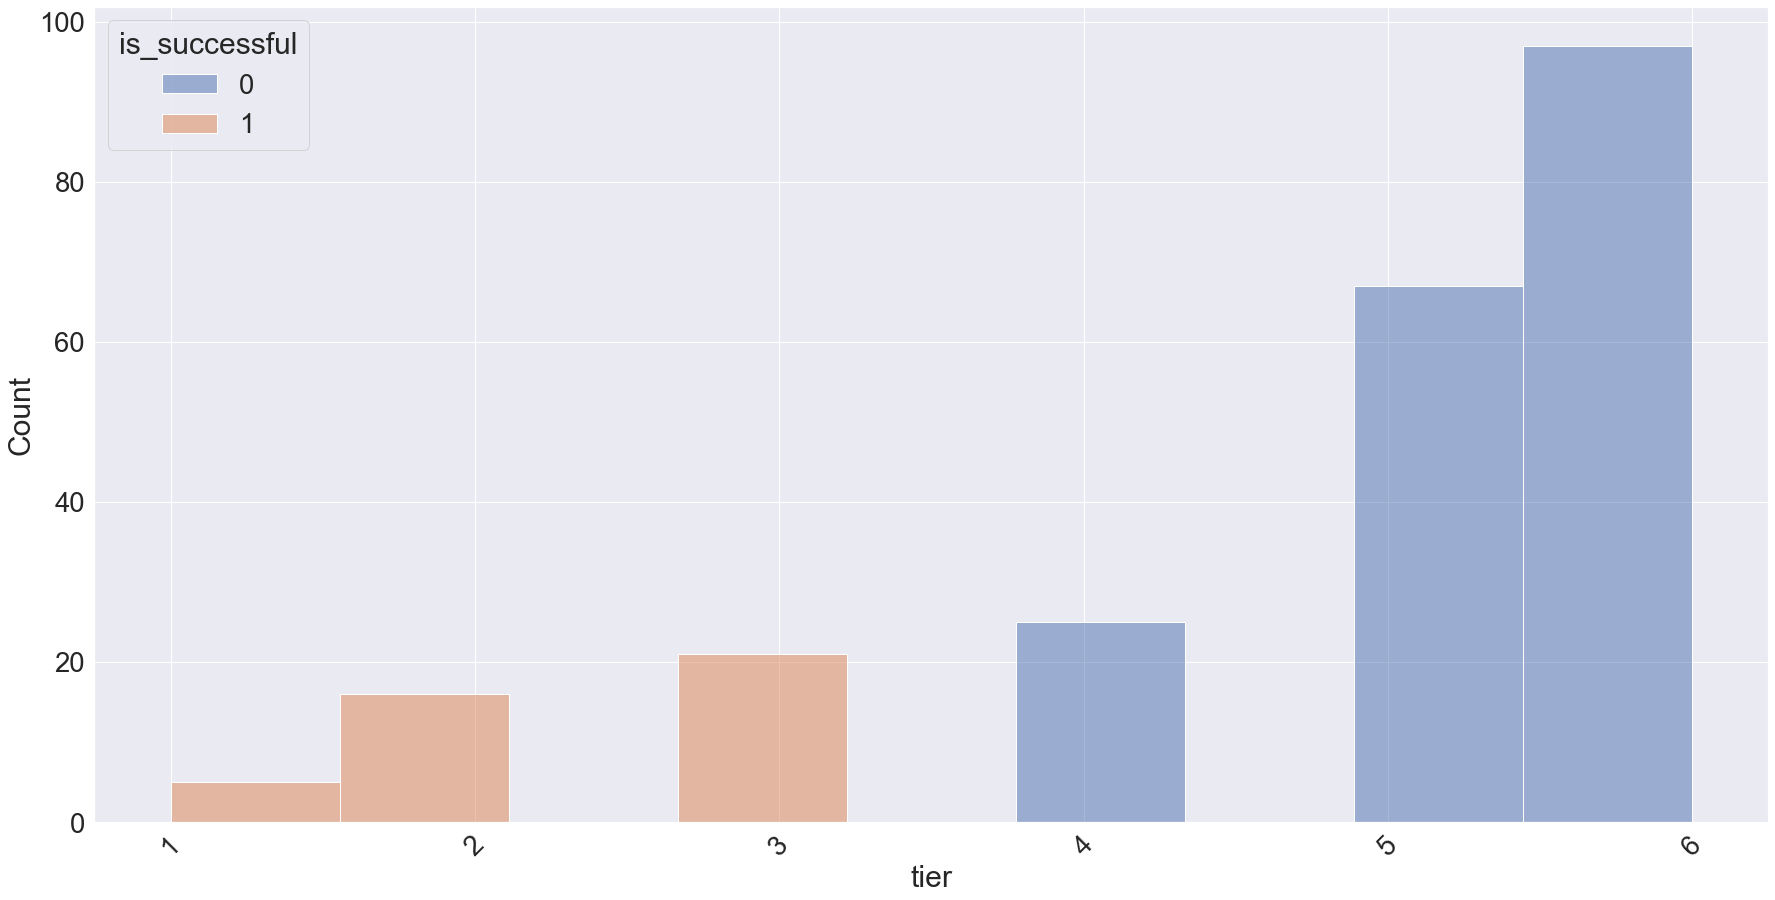

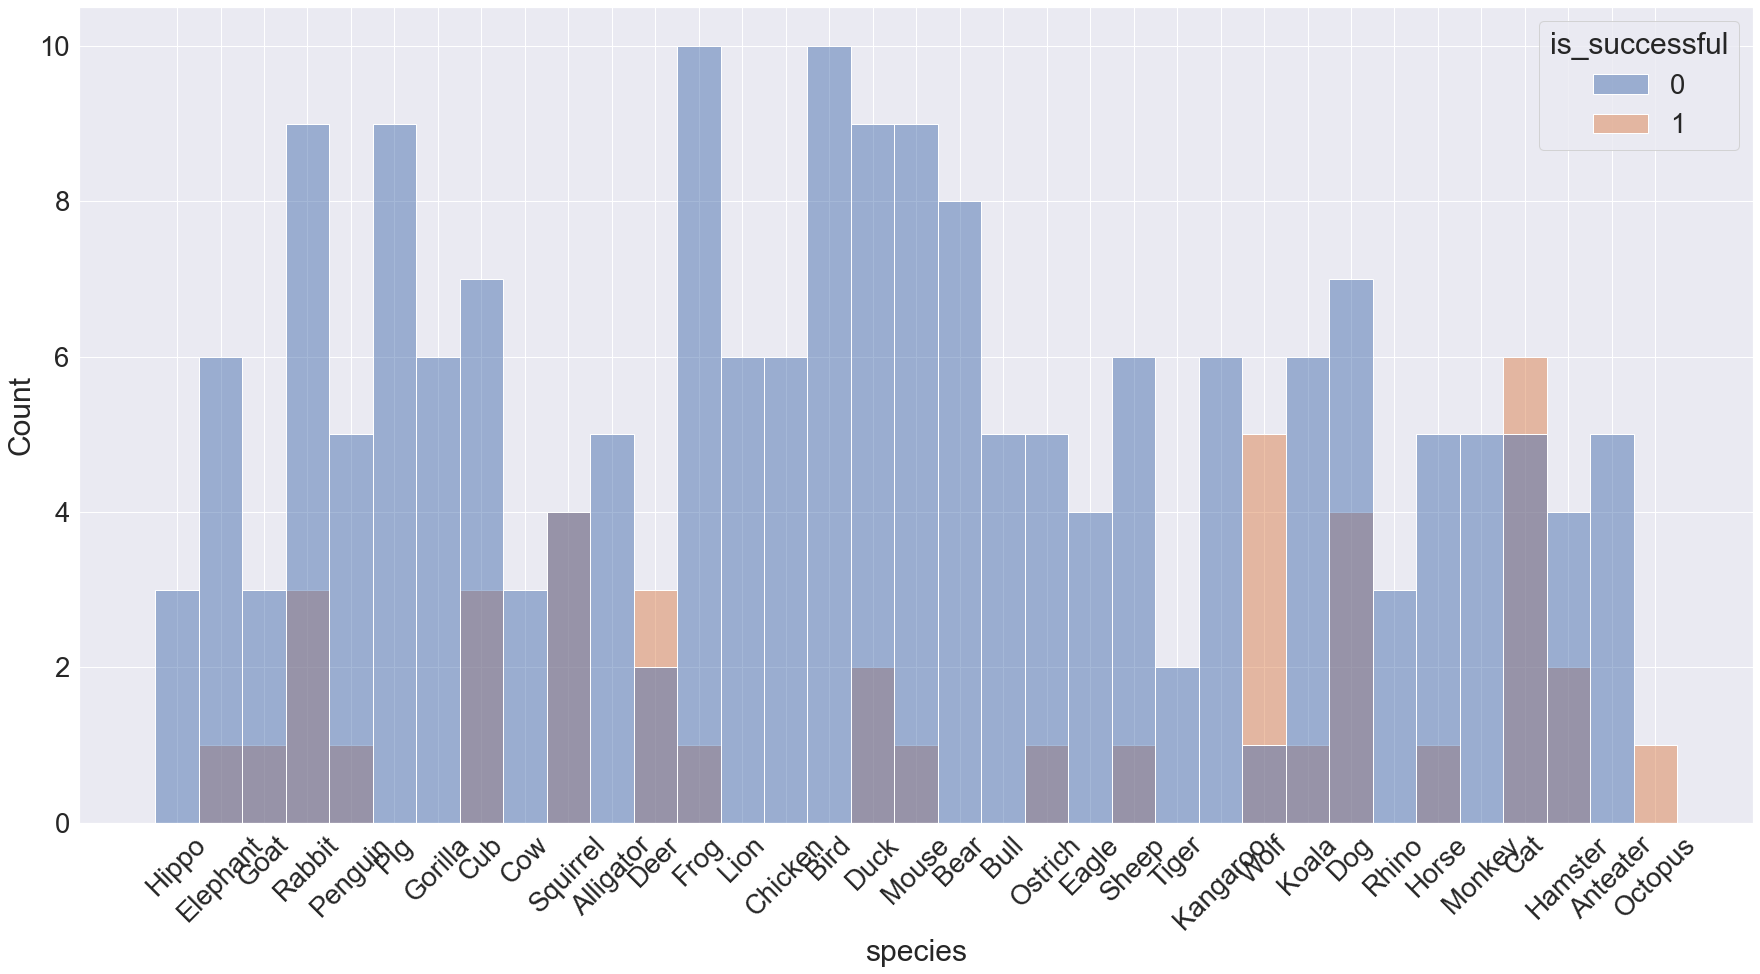

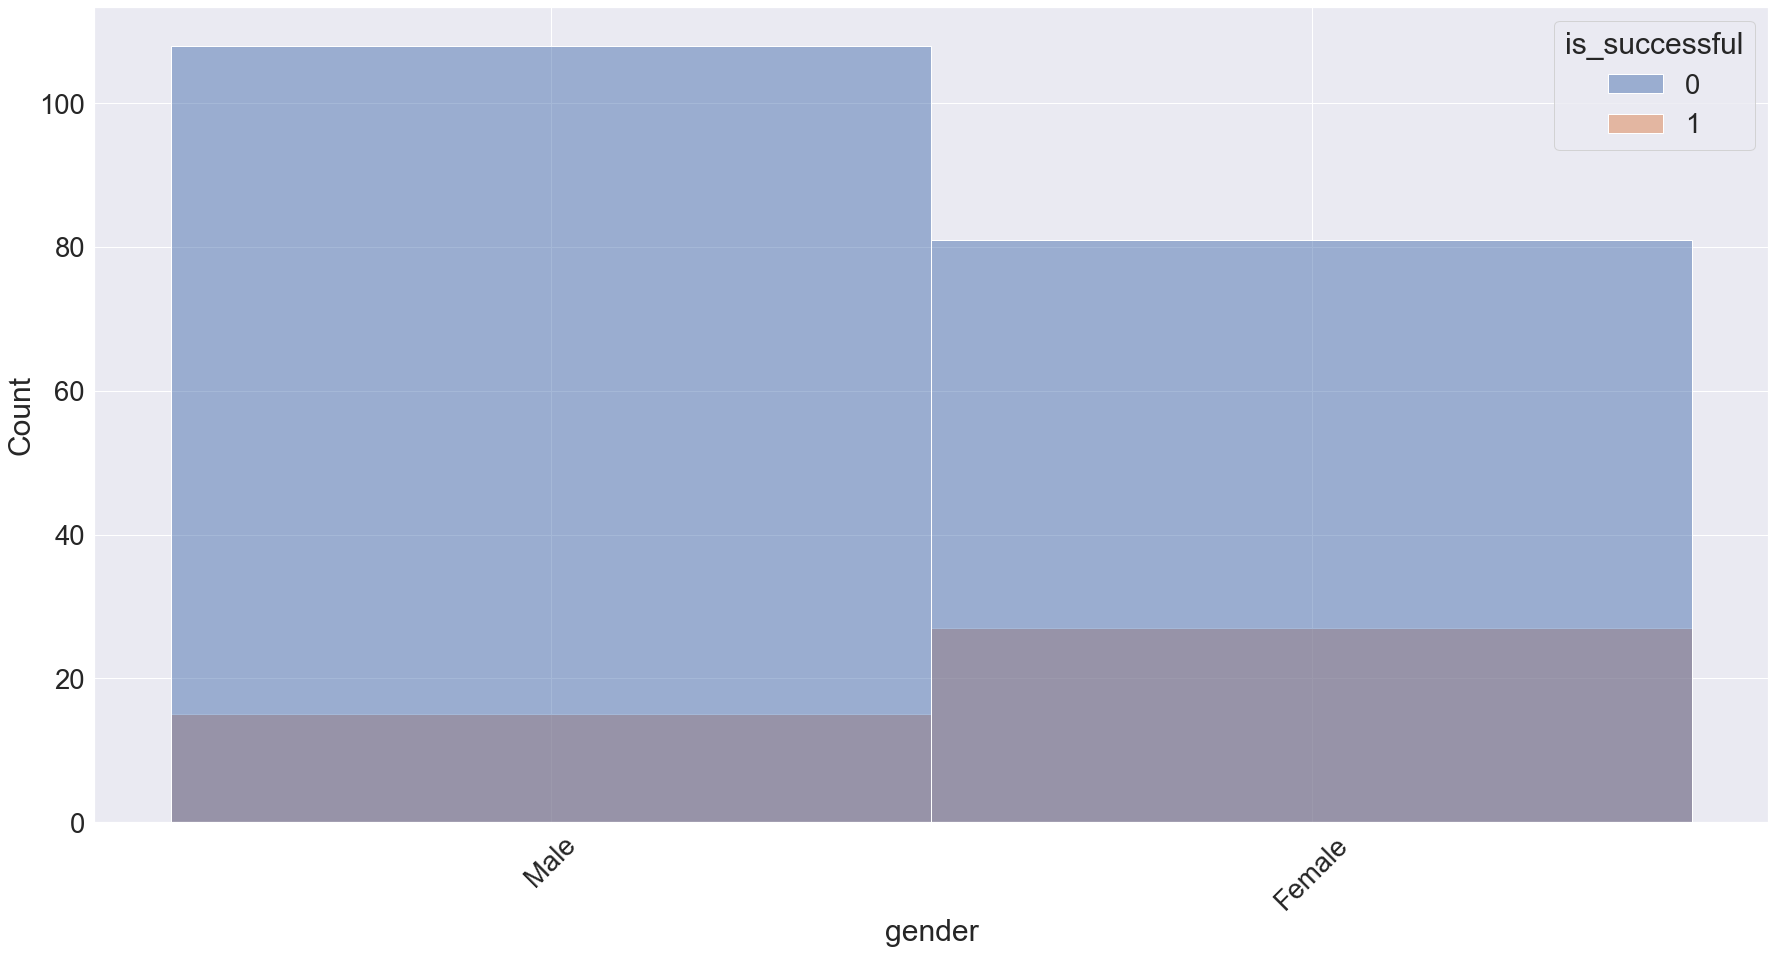

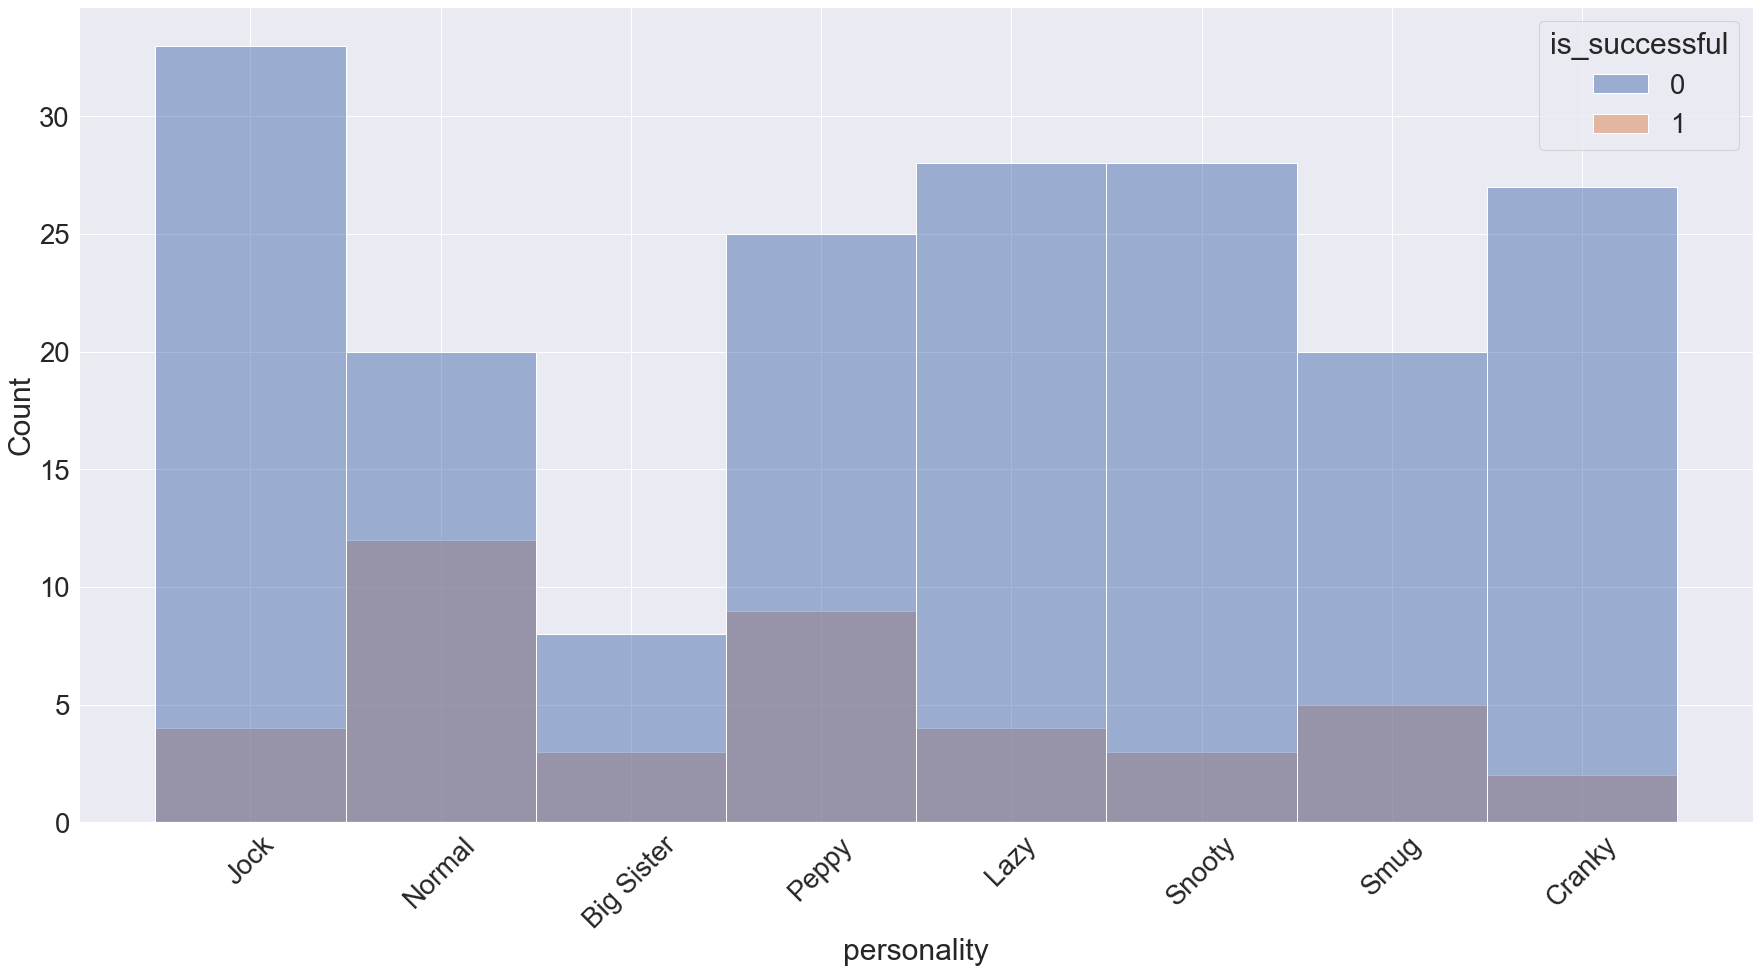

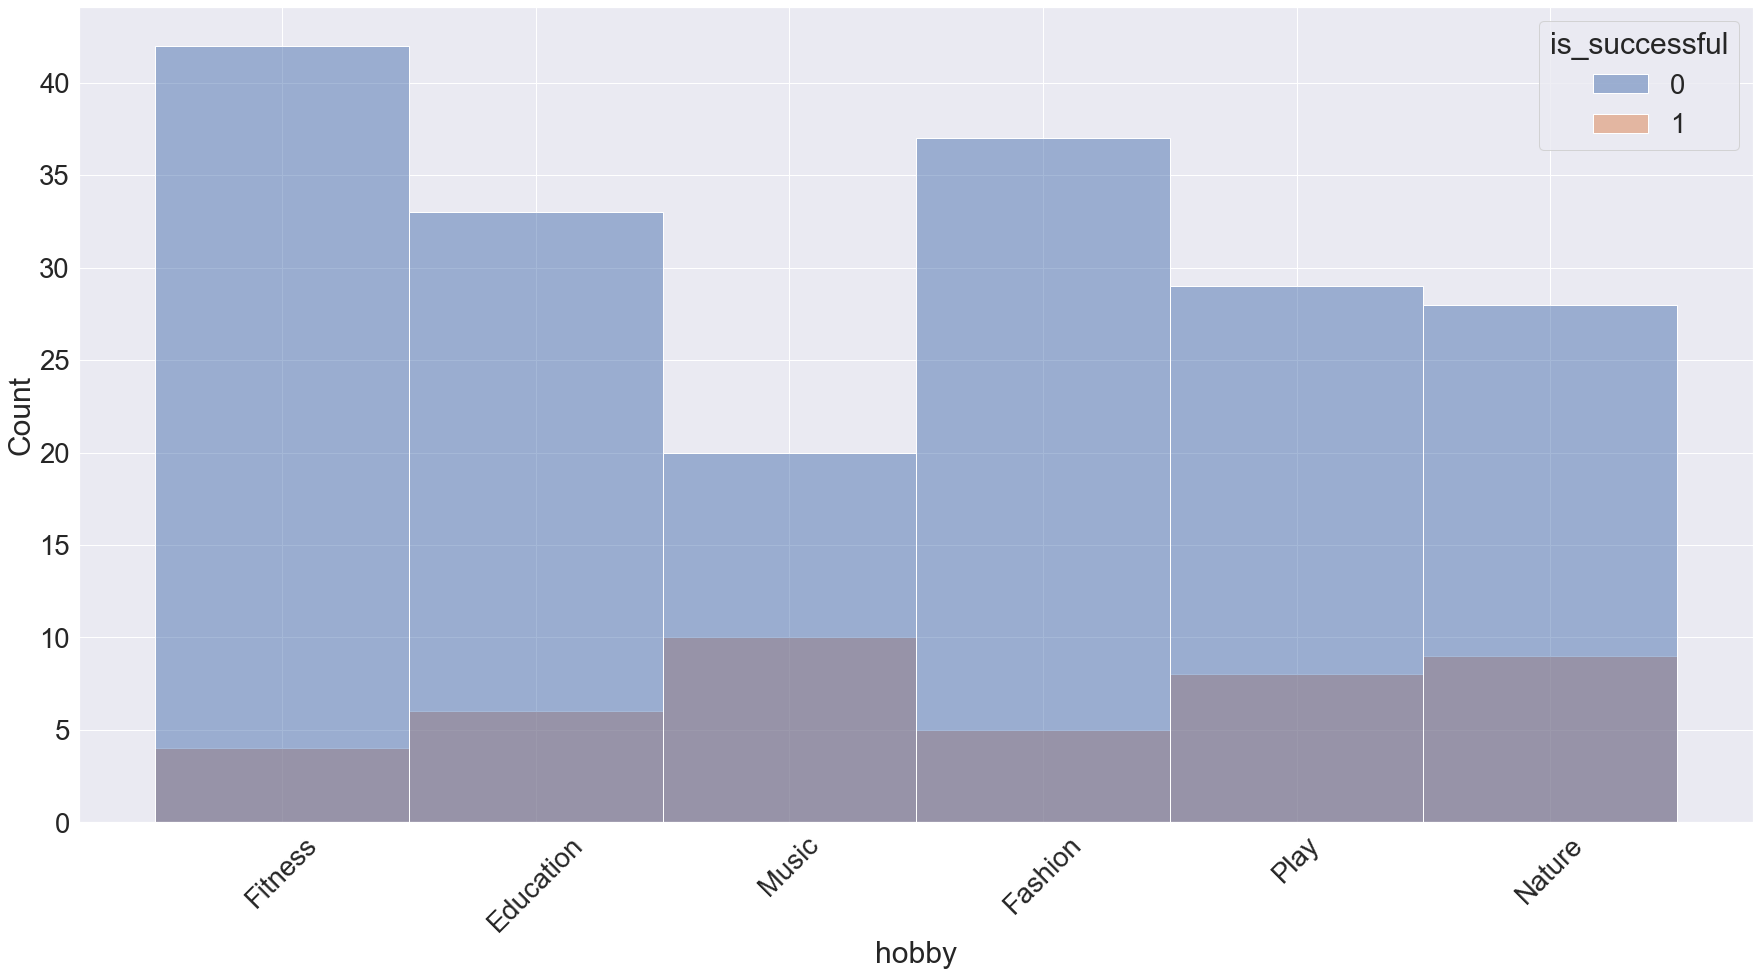

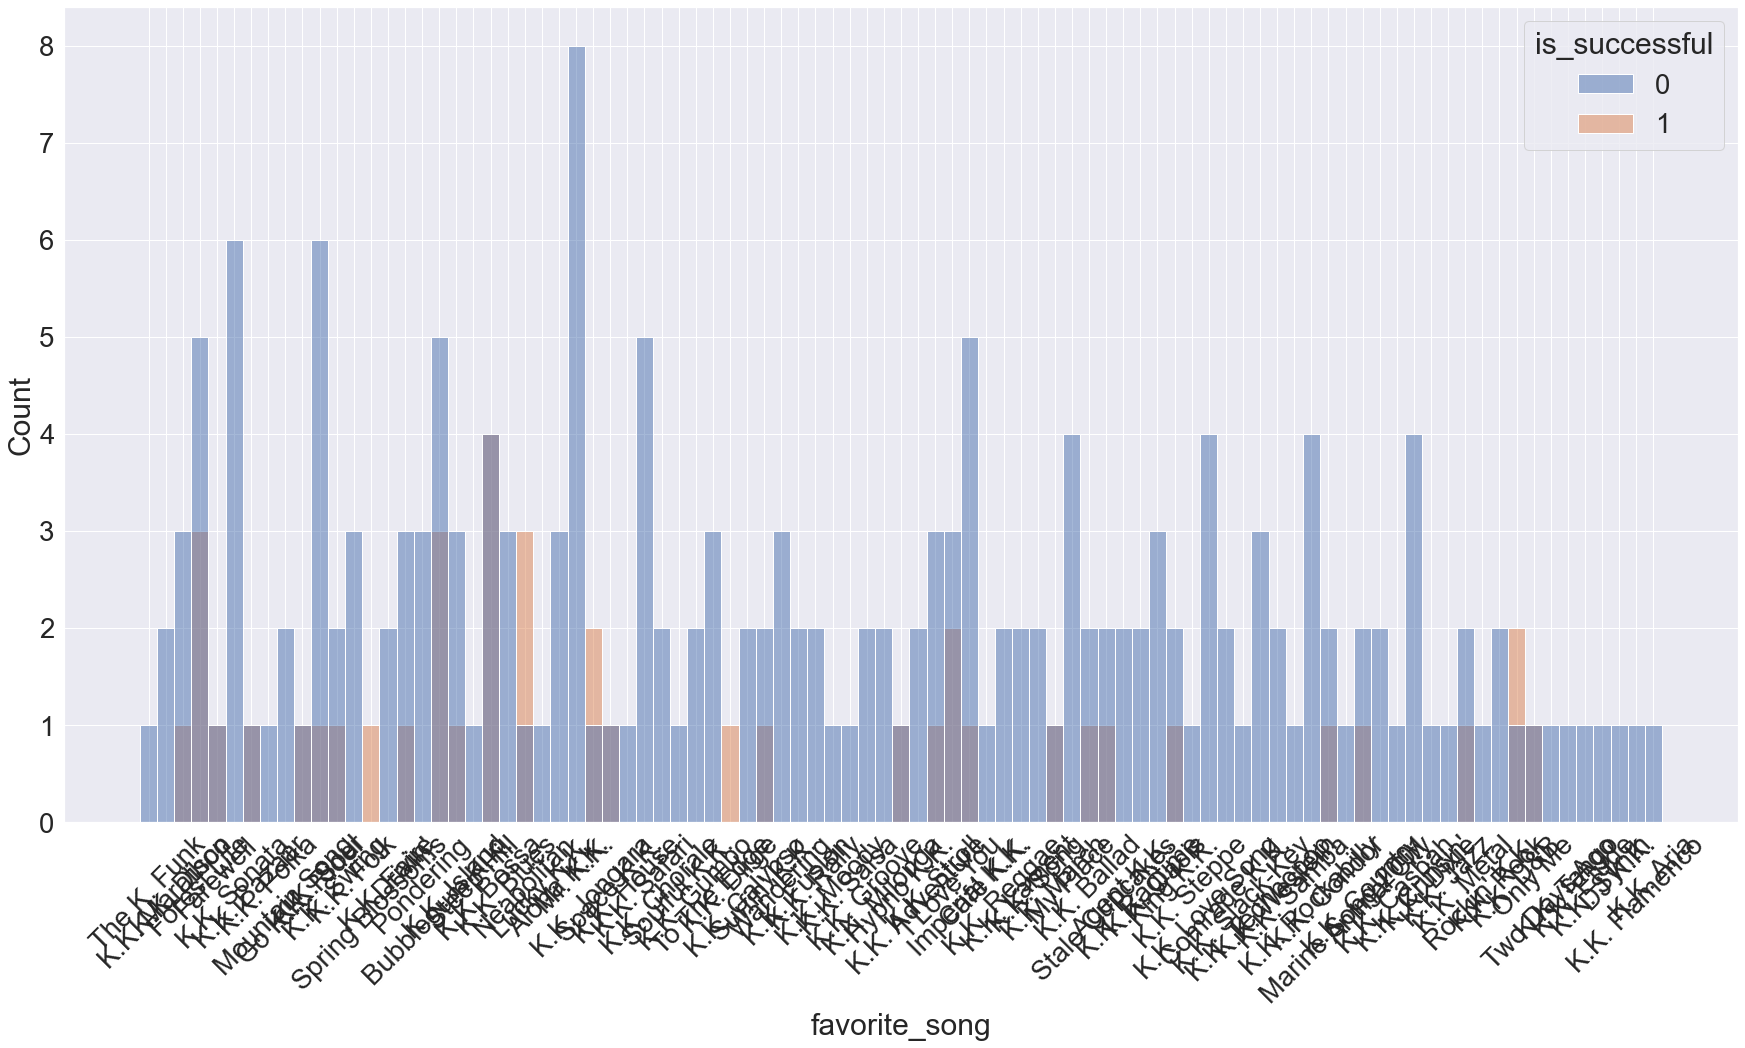

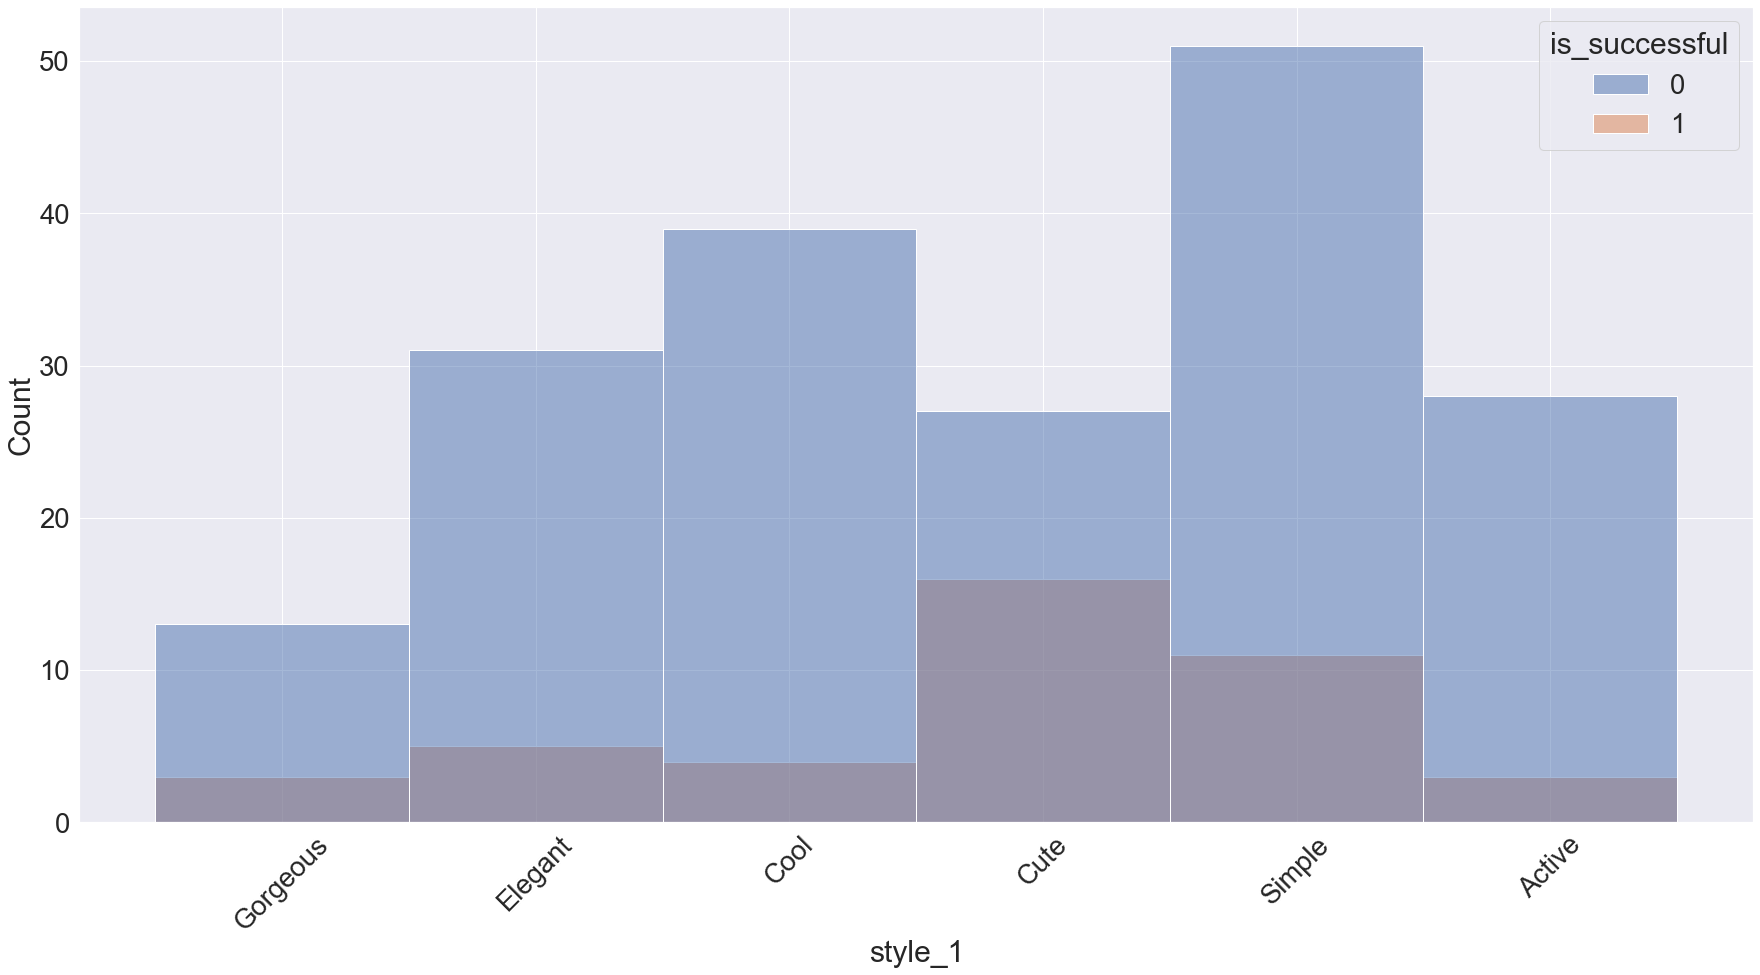

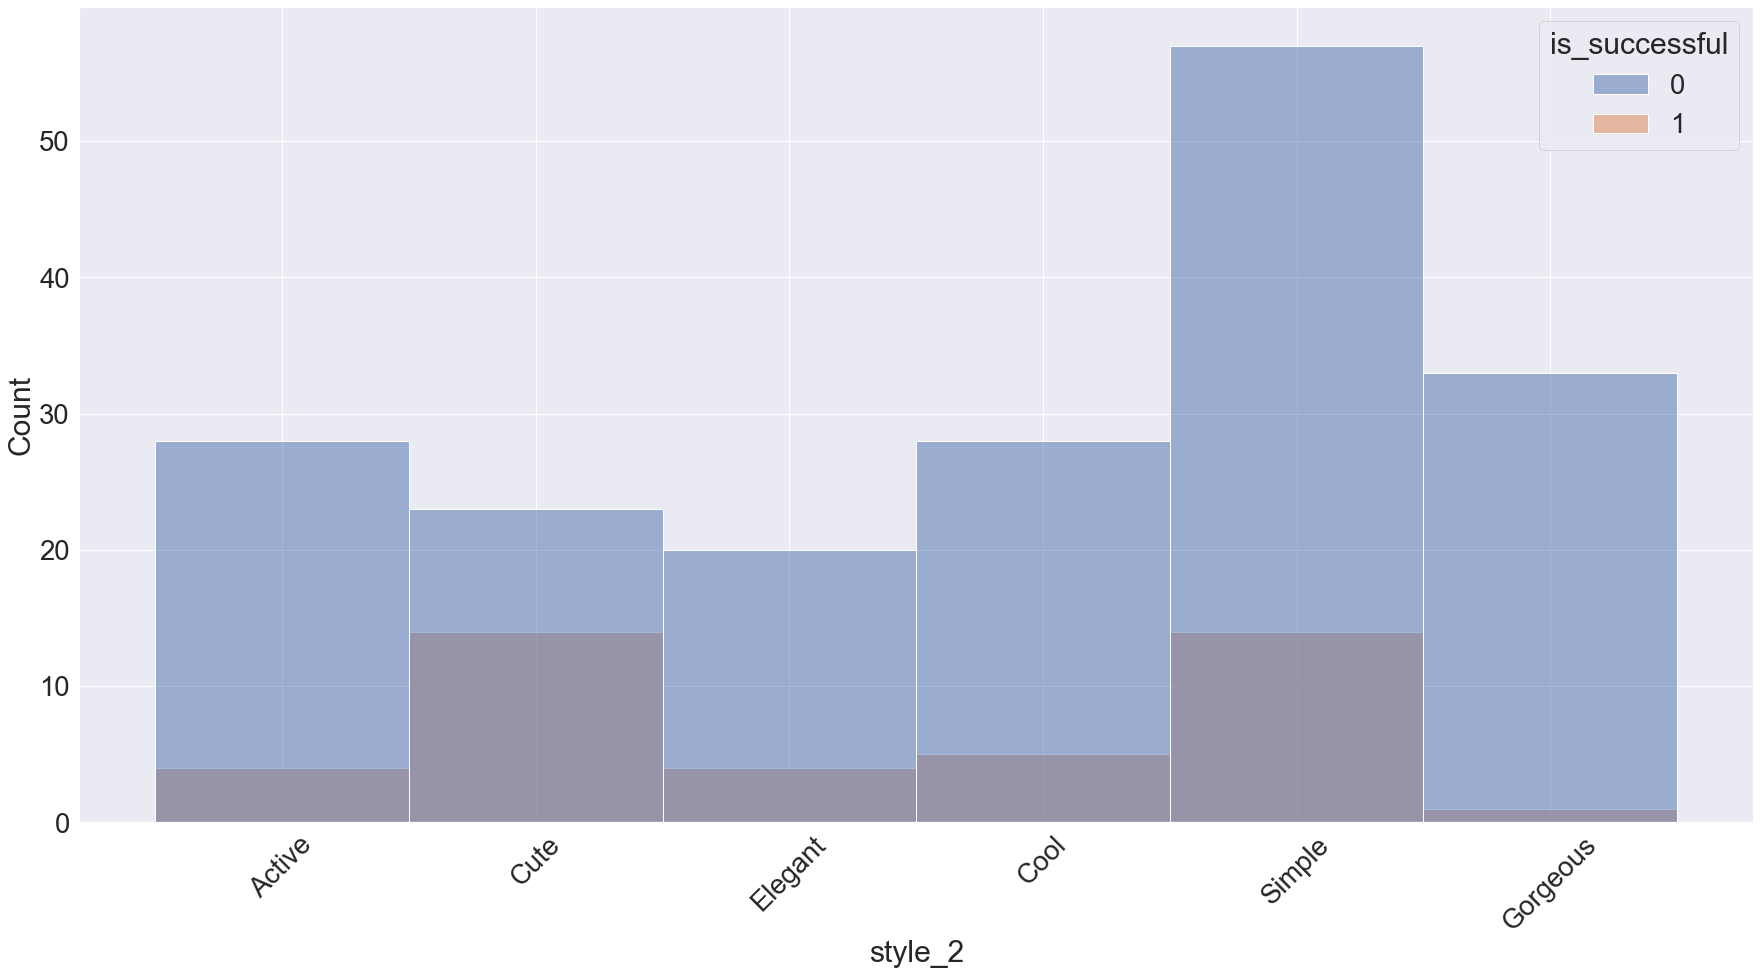

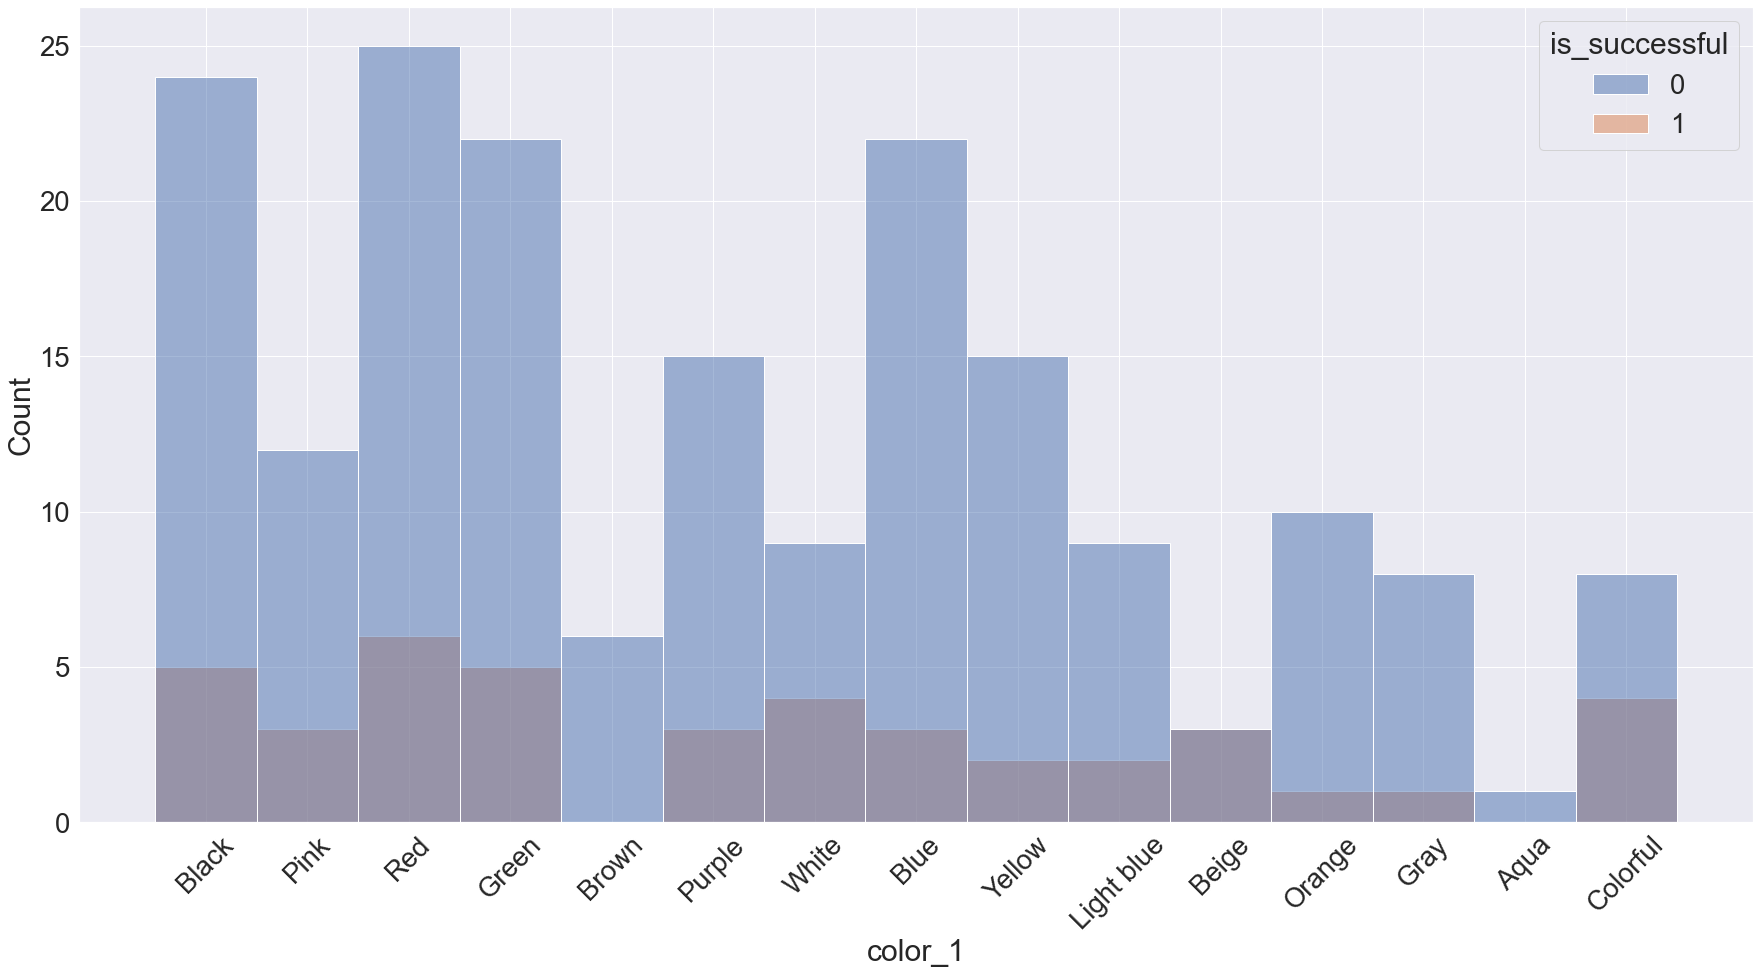

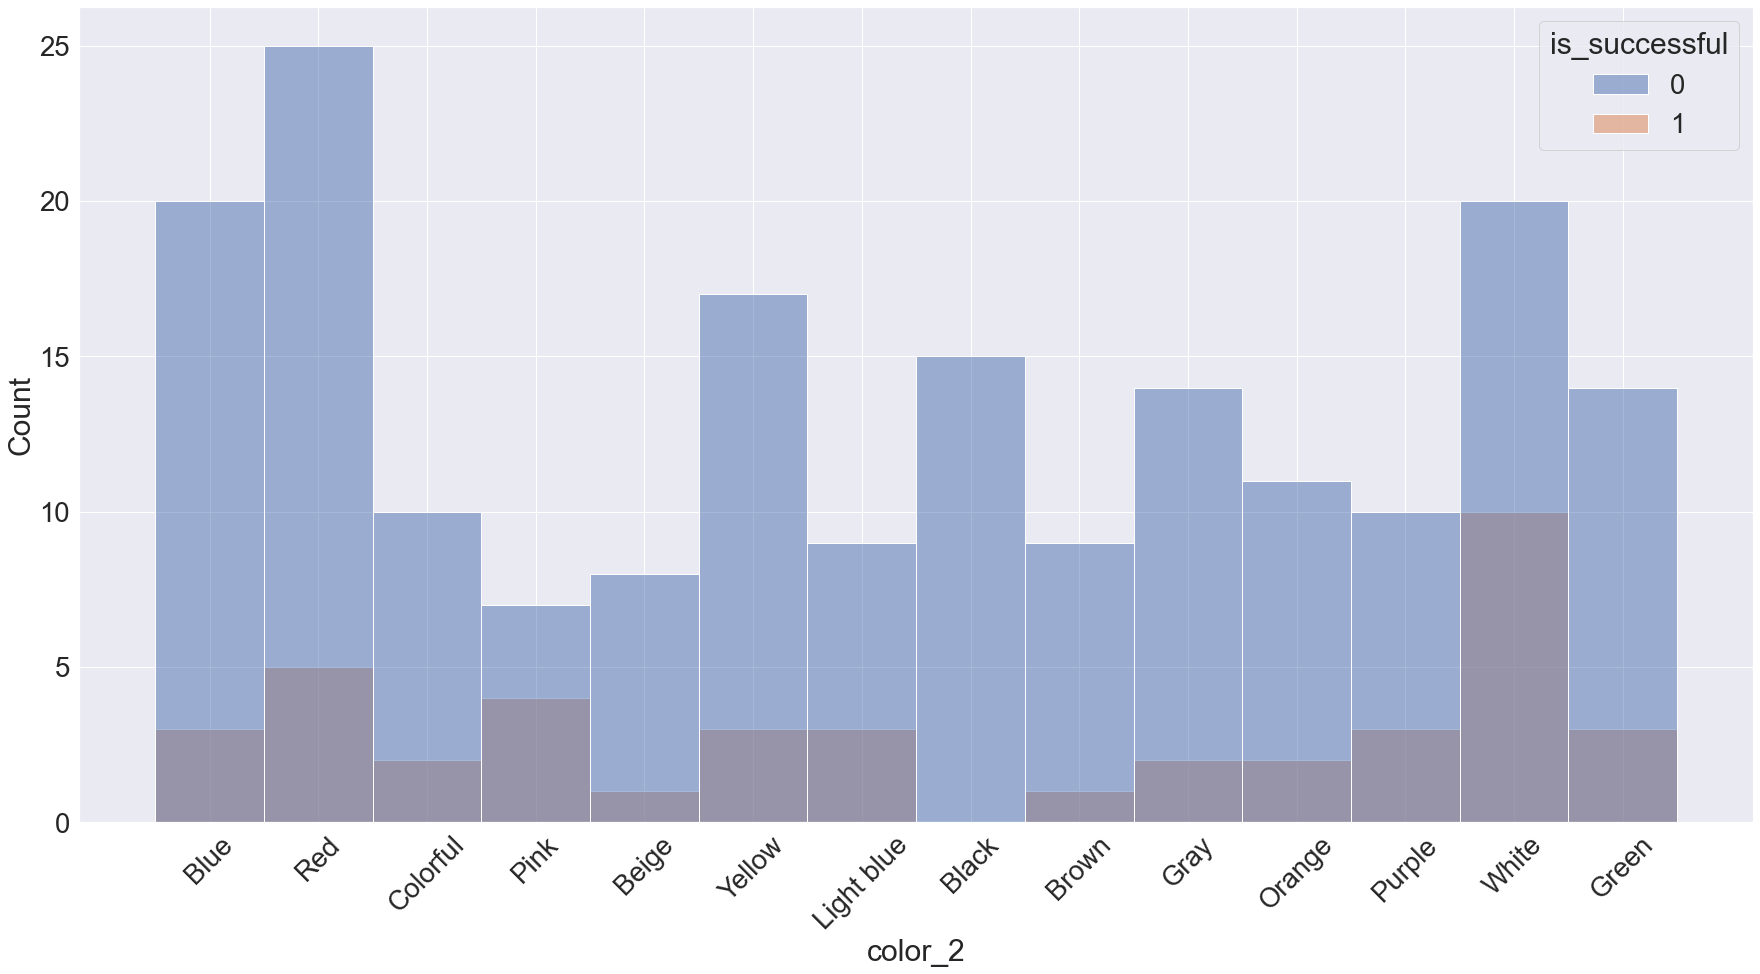

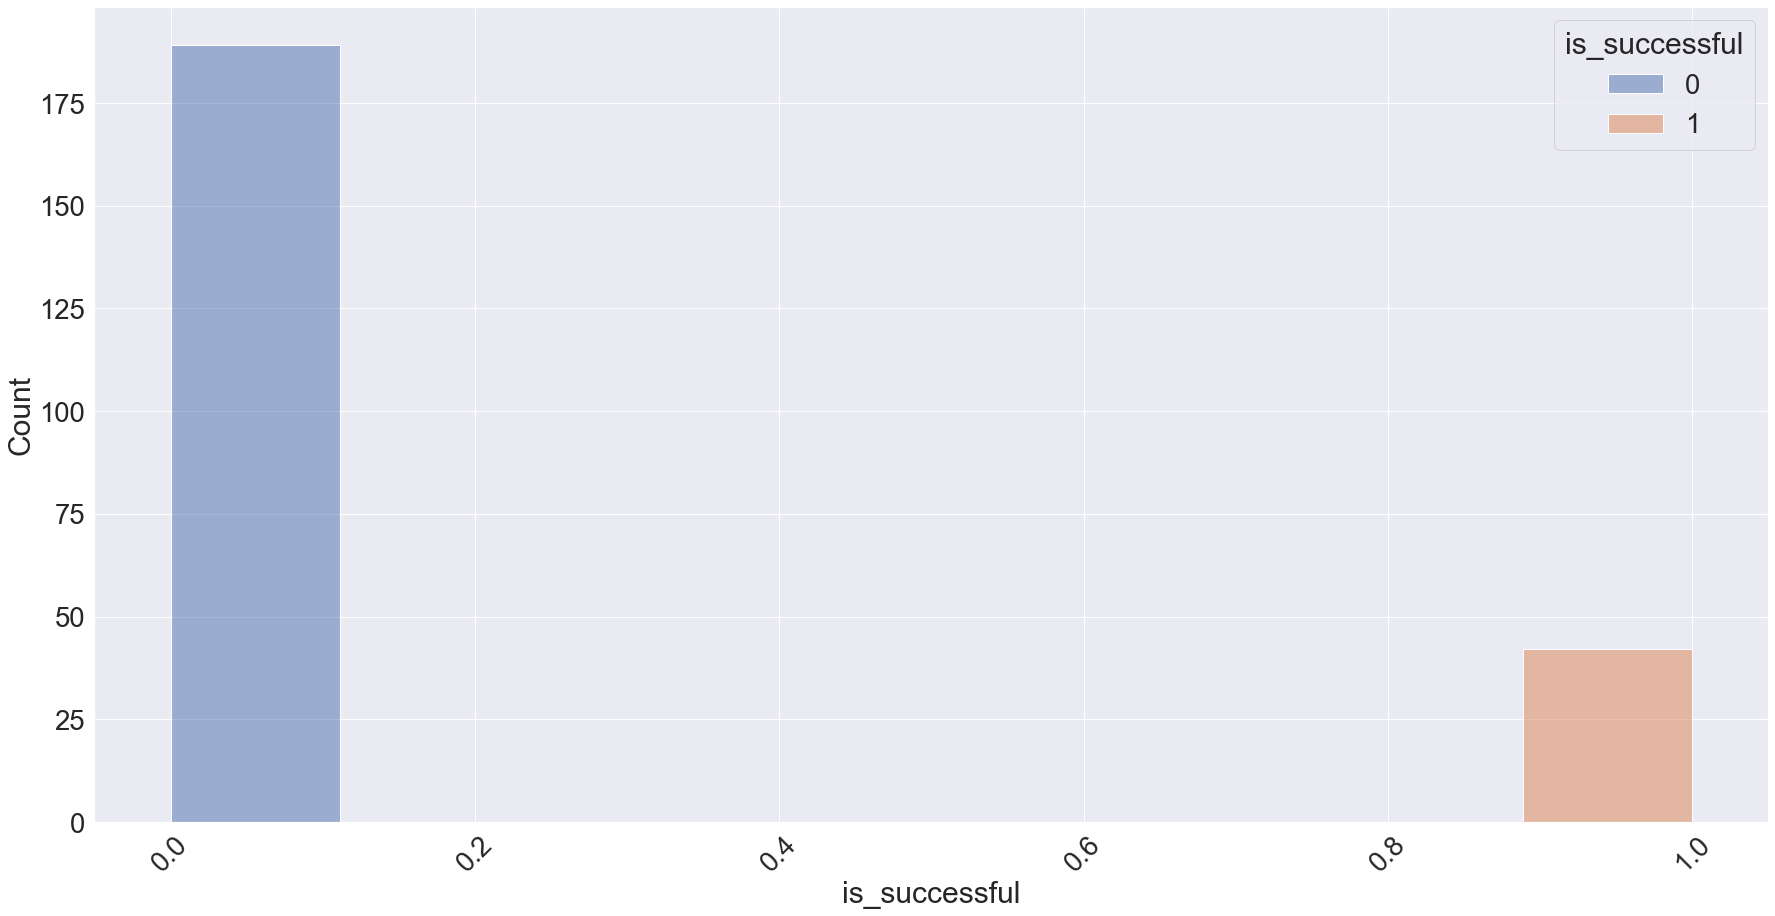

In [11]:
column_hist_plots(train)

### Takeaways: 
- The wolf, deer, hamster, cat, and octopus species have more successful characters than they have unsuccessful characters
    - There are multiple species with no successful characters
- Female characters seem to have a higher percentage of success than male characters
- The normal, lazy, peppy, and big sister columns seem to have the highest percents of success and the snooty seems to perform the worst. 
- The nature and music hobbies seem to do the best, and the fitness seems to do the worst. 
- The cute and simple style seem to perform the best for style_1
- The cute style does very well in style_2. The simple style still does well, the gorgeous style seems to do the worst
- Beige, white, and colorful are very successful colors for color 1. Orange is not very successful
- Brown, light blue, and white seem to do well while beige and black don't seem to do as well for color_2.

In [12]:
# establish an overall mean of the position column 
overall_mean = train.position.mean()

In [13]:
# create a dictionary that has the average position for the groups of each column

def trait_means_dicts(train):
    df_dict = {}

    for col in train.drop(columns = 'position').columns:
        df= train.groupby(col).mean()['position'].to_frame().reset_index().sort_values('position')
        df_dict[col] = df
    return df_dict

In [14]:
# display the entire dictionary

trait_means_dicts(train)

{'tier':    tier             position
 0     1                 7.80
 1     2                27.88
 2     3                55.33
 3     4               101.36
 4     5               188.82
 5     6               328.02,
 'species':       species             position
 25    Octopus                28.00
 34       Wolf                54.00
 5         Cat                89.18
 9        Deer               107.00
 17    Hamster               122.50
 32   Squirrel               134.25
 10        Dog               146.27
 27    Penguin               159.50
 8         Cub               172.50
 21      Koala               173.43
 31      Sheep               179.00
 29     Rabbit               181.08
 13   Elephant               187.00
 15       Goat               198.50
 26    Ostrich               199.50
 2        Bear               203.62
 0   Alligator               217.00
 12      Eagle               218.75
 19      Horse               223.83
 7         Cow               227.00
 14       Frog

In [15]:
# a list of the different dictionaries that cna be accessed with this function
list(trait_means_dicts(train))

['tier',
 'species',
 'gender',
 'personality',
 'hobby',
 'favorite_song',
 'style_1',
 'style_2',
 'color_1',
 'color_2',
 'is_successful']

In [16]:
# this dictionary allows me to access the mean position for each group of a category by knowing just the name of the column
# This can be used later for graphing the means of the group instead of each point
trait_means_dicts(train)['hobby']

,hobby,position
5,Play,171.32
3,Music,182.20
4,Nature,185.76
0,Education,224.92
1,Fashion,228.81
2,Fitness,251.96


In [17]:
# function takes the mean of the groups of each column and plots them against the average position
def column_scatter_plots(train):
    for col in train.drop(columns = 'position').columns:
        plt.figure(figsize=(30,15))
        sns.set(font_scale=2.5)
        plt.xticks(rotation=45)
        plt.axhline(overall_mean, color='r')
        sns.scatterplot(x=col, y='position', data=trait_means_dicts(train)[col],label='mean_overall', s=300)

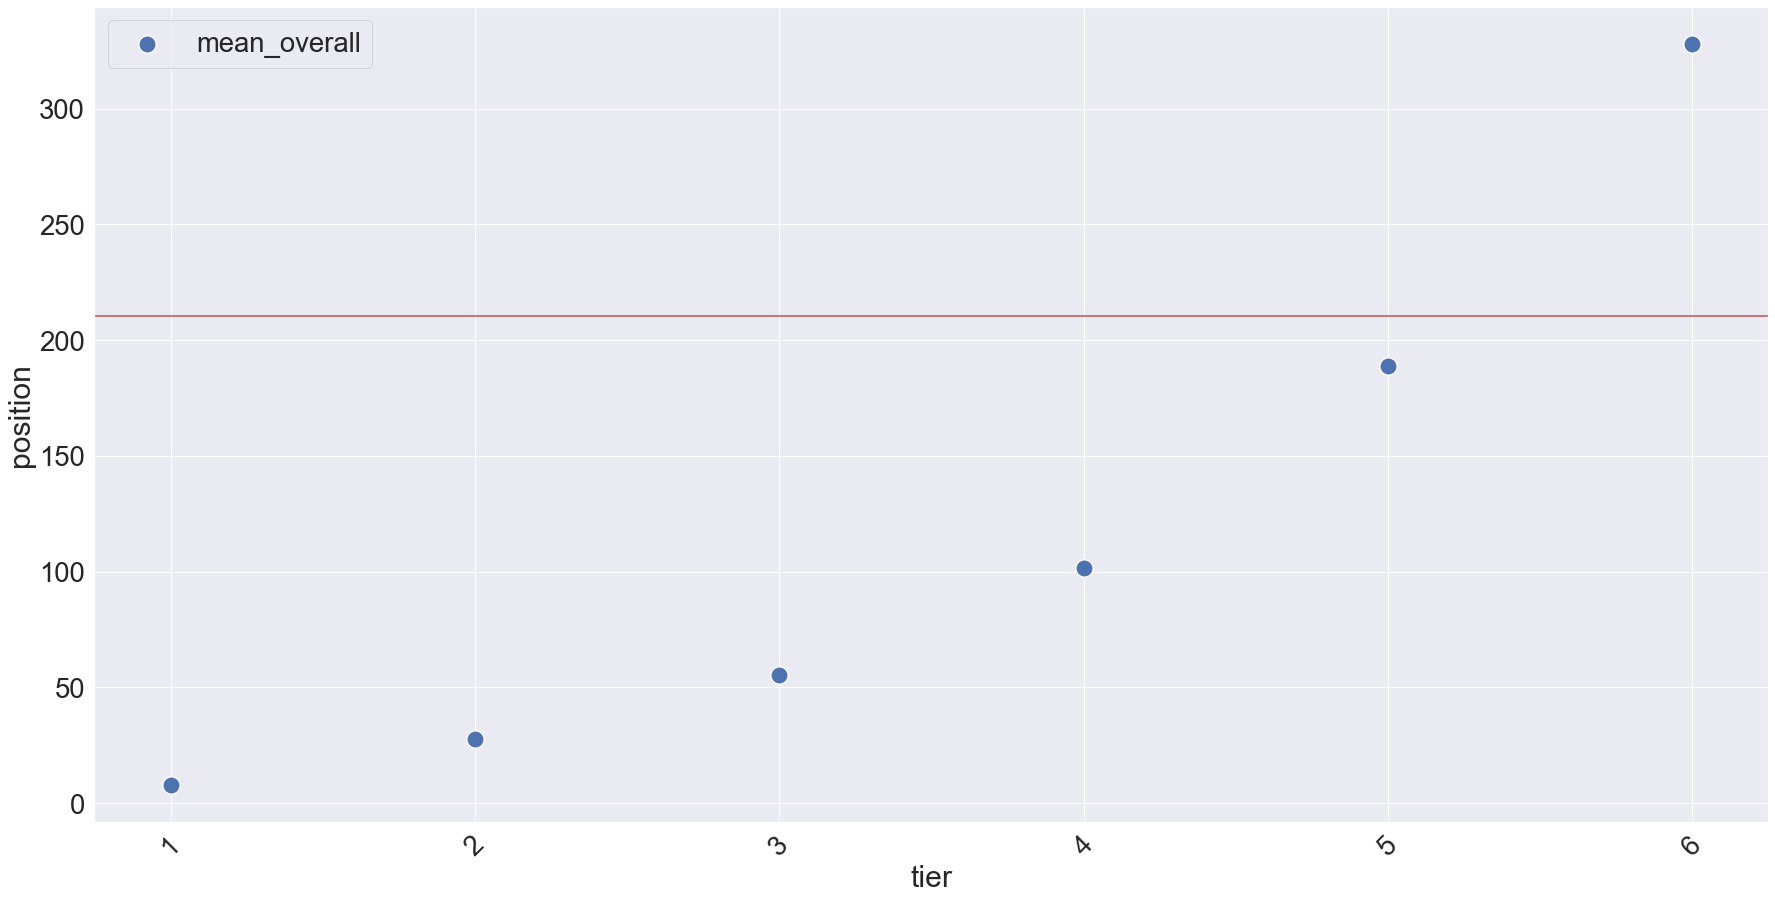

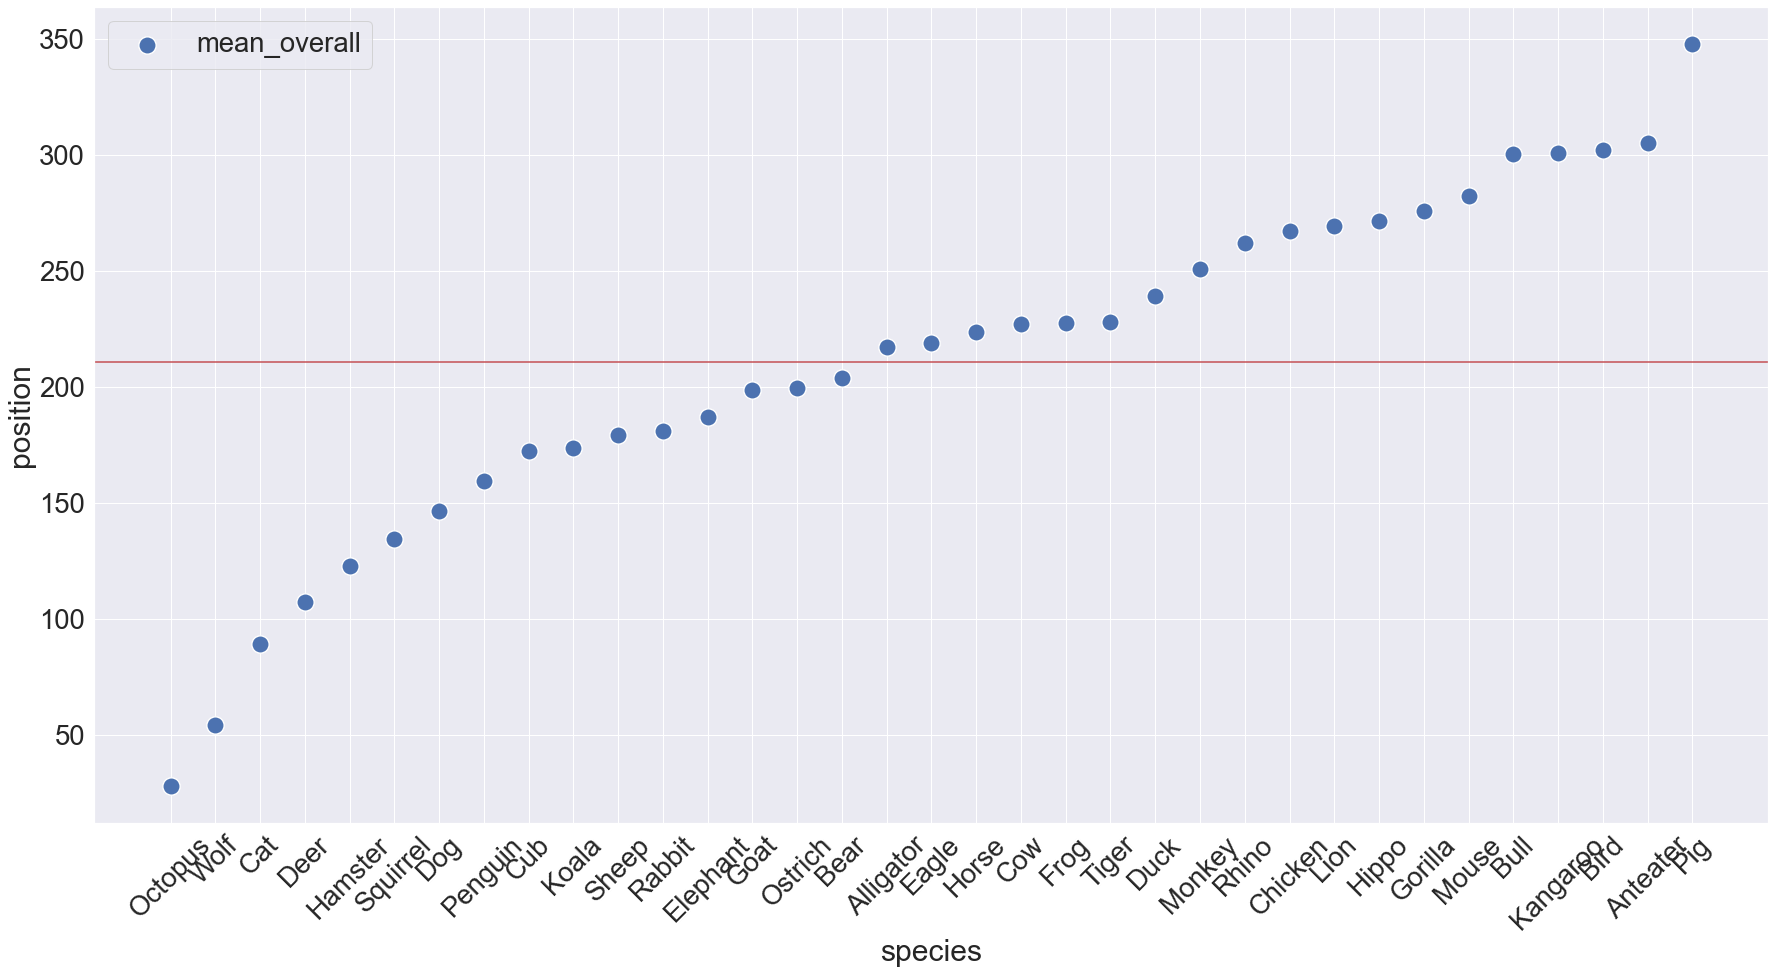

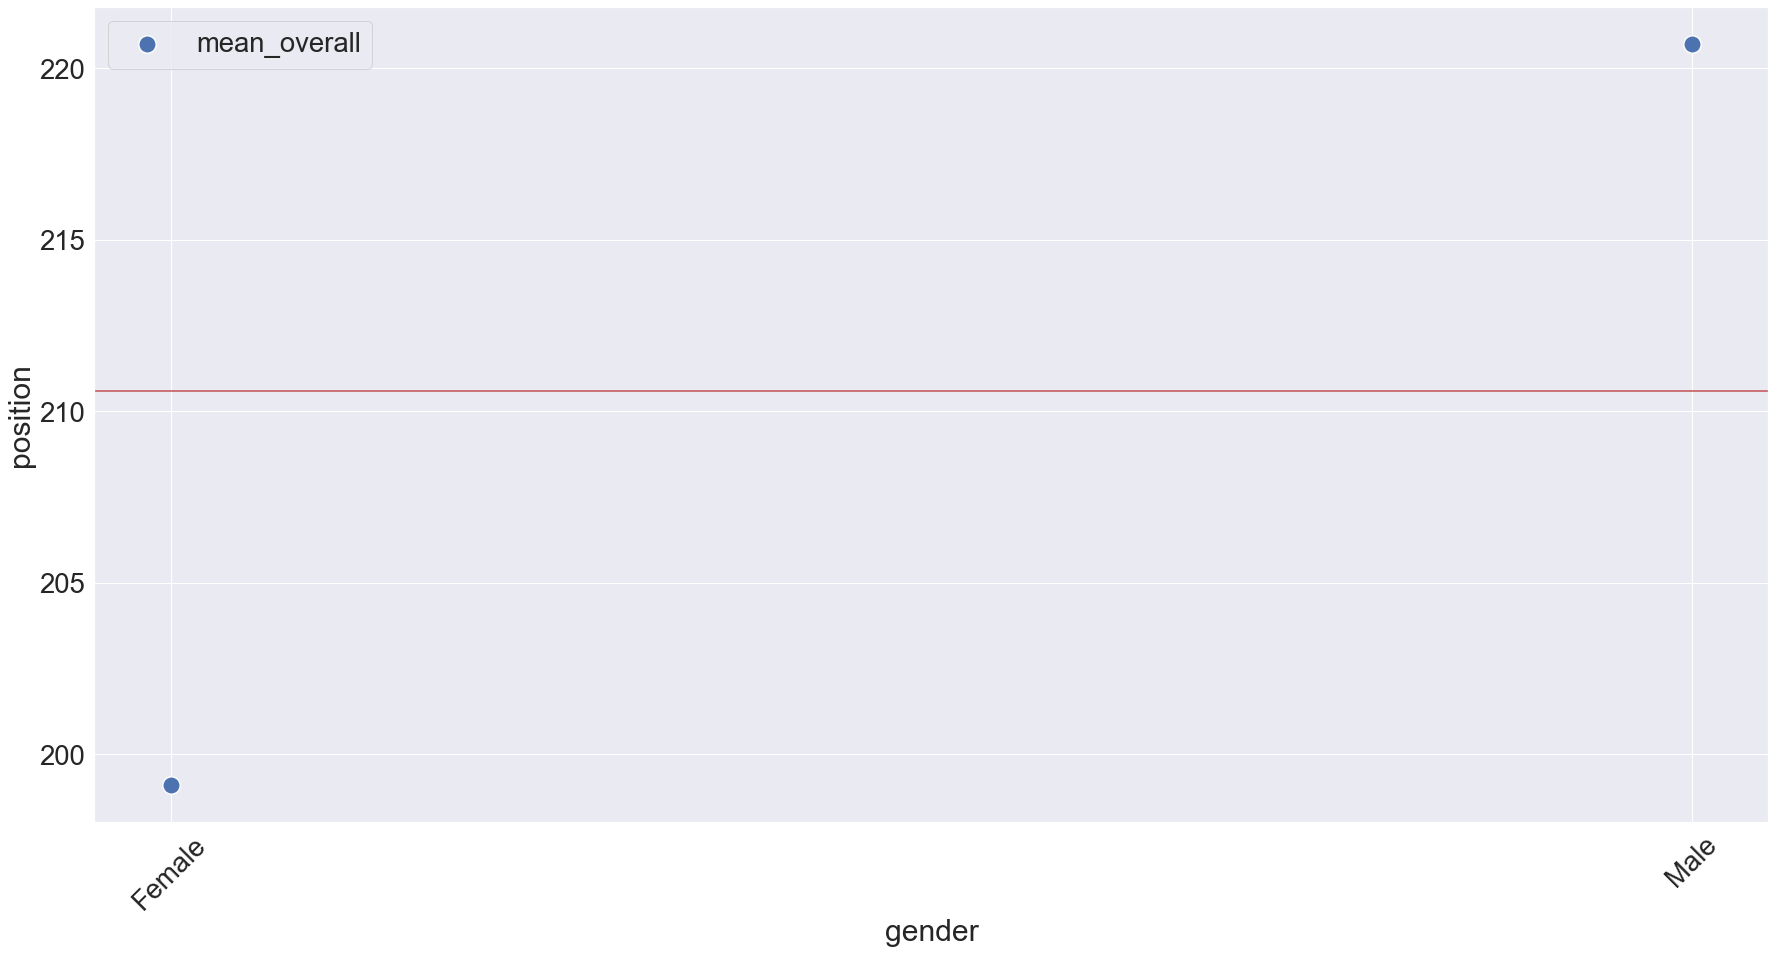

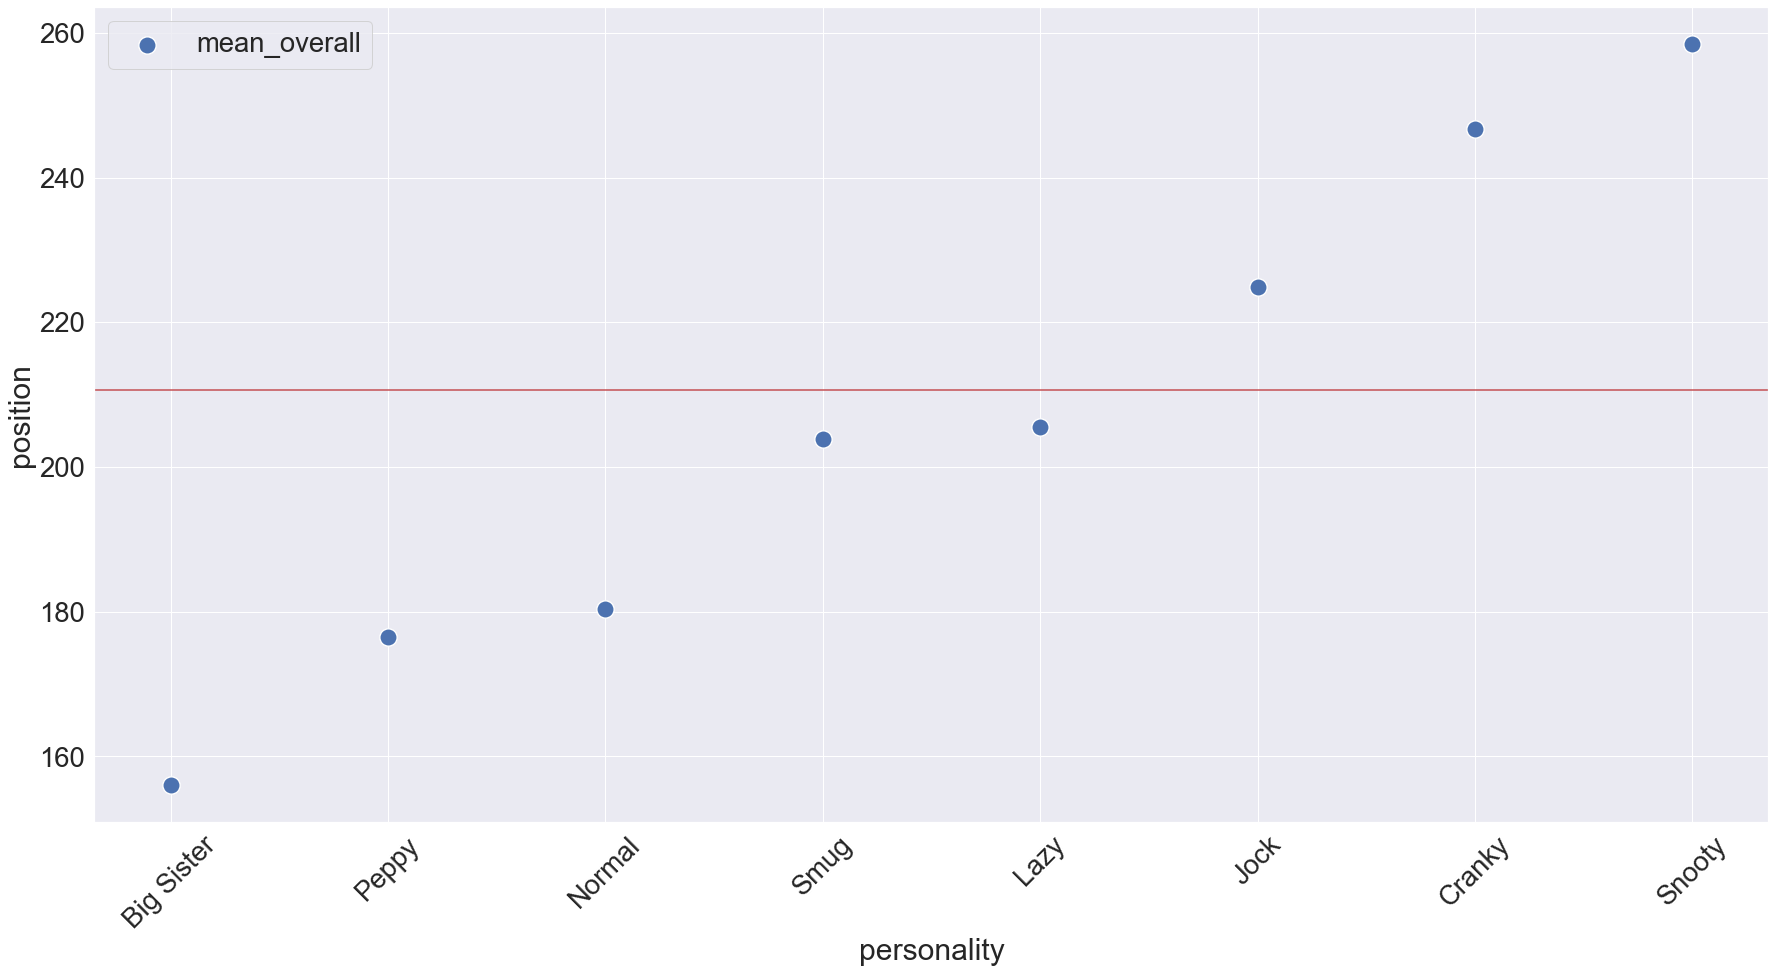

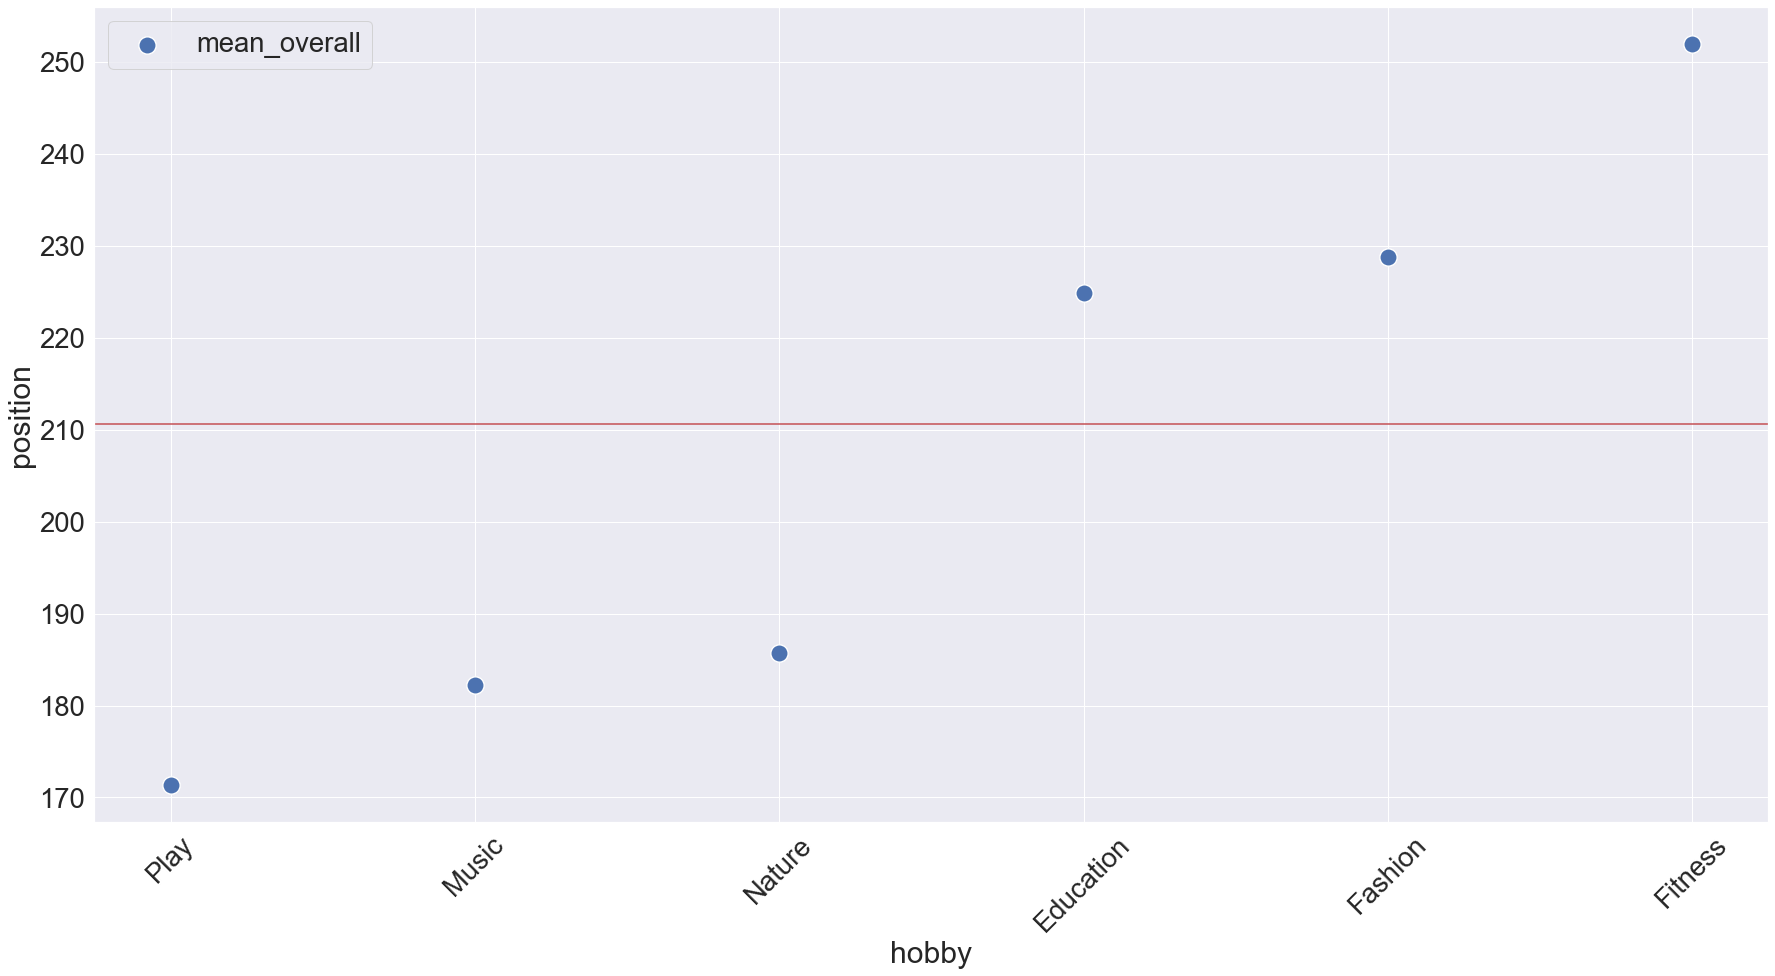

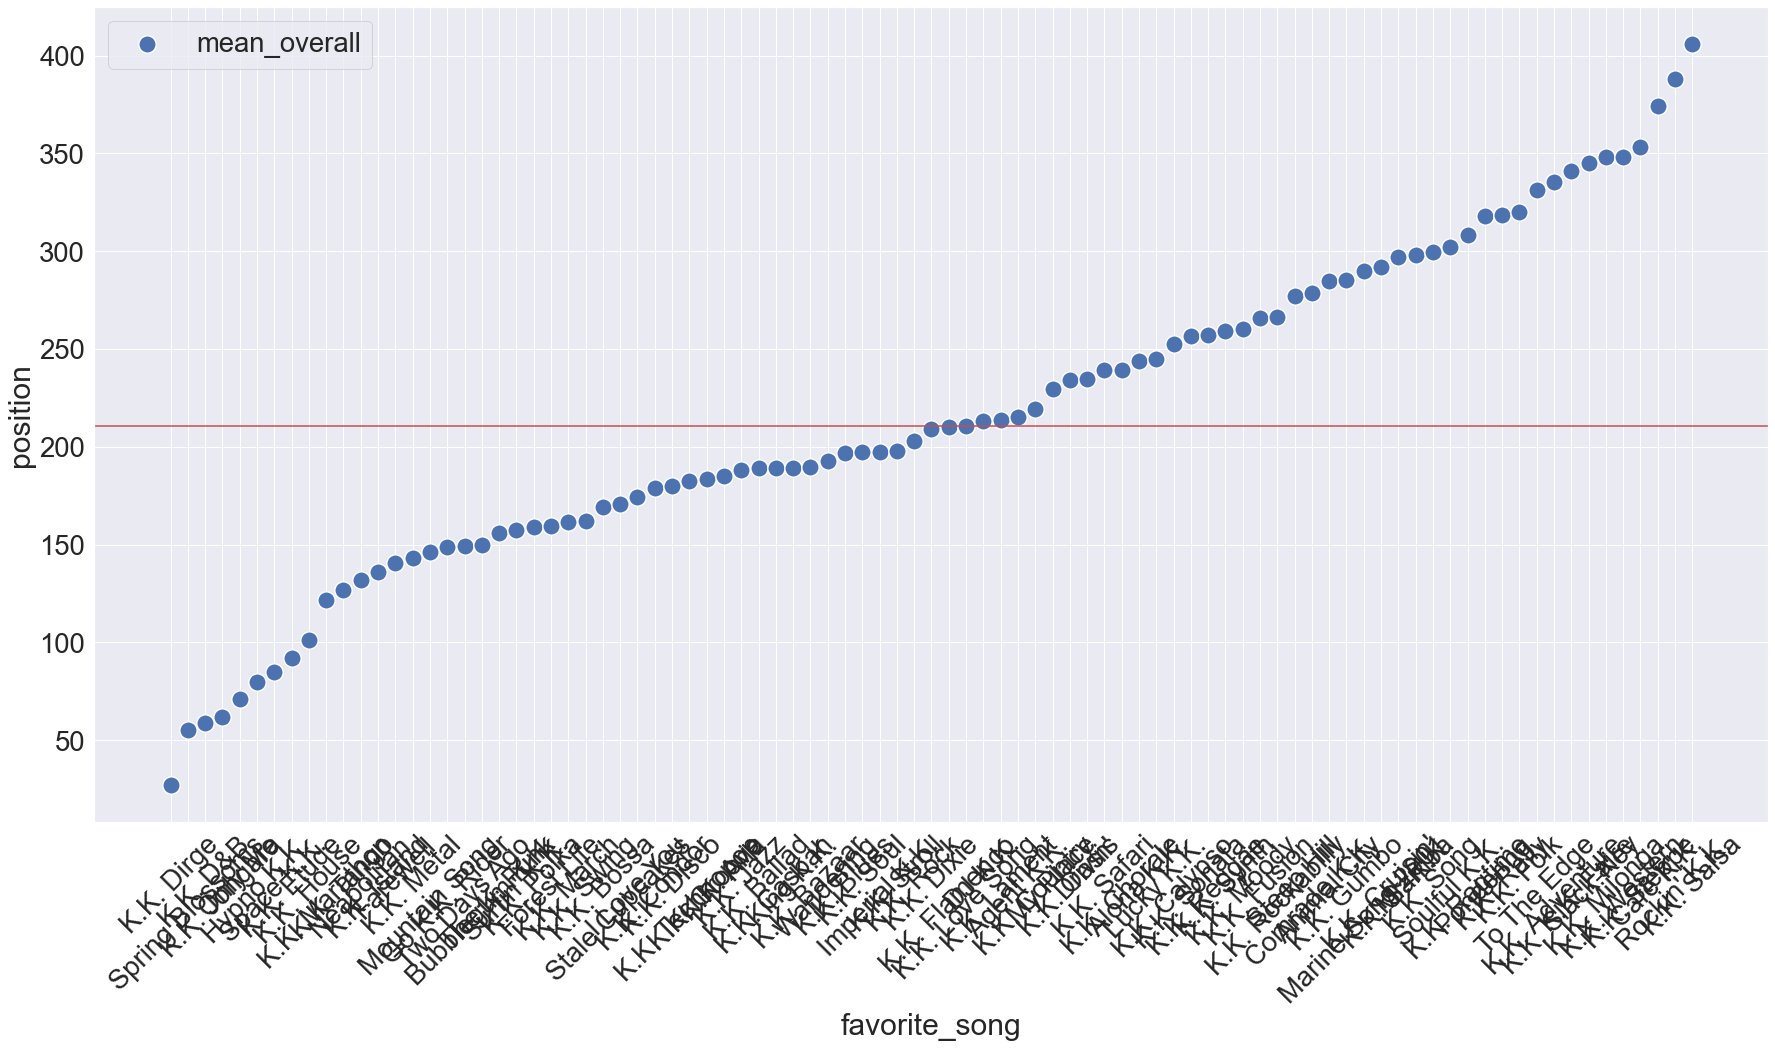

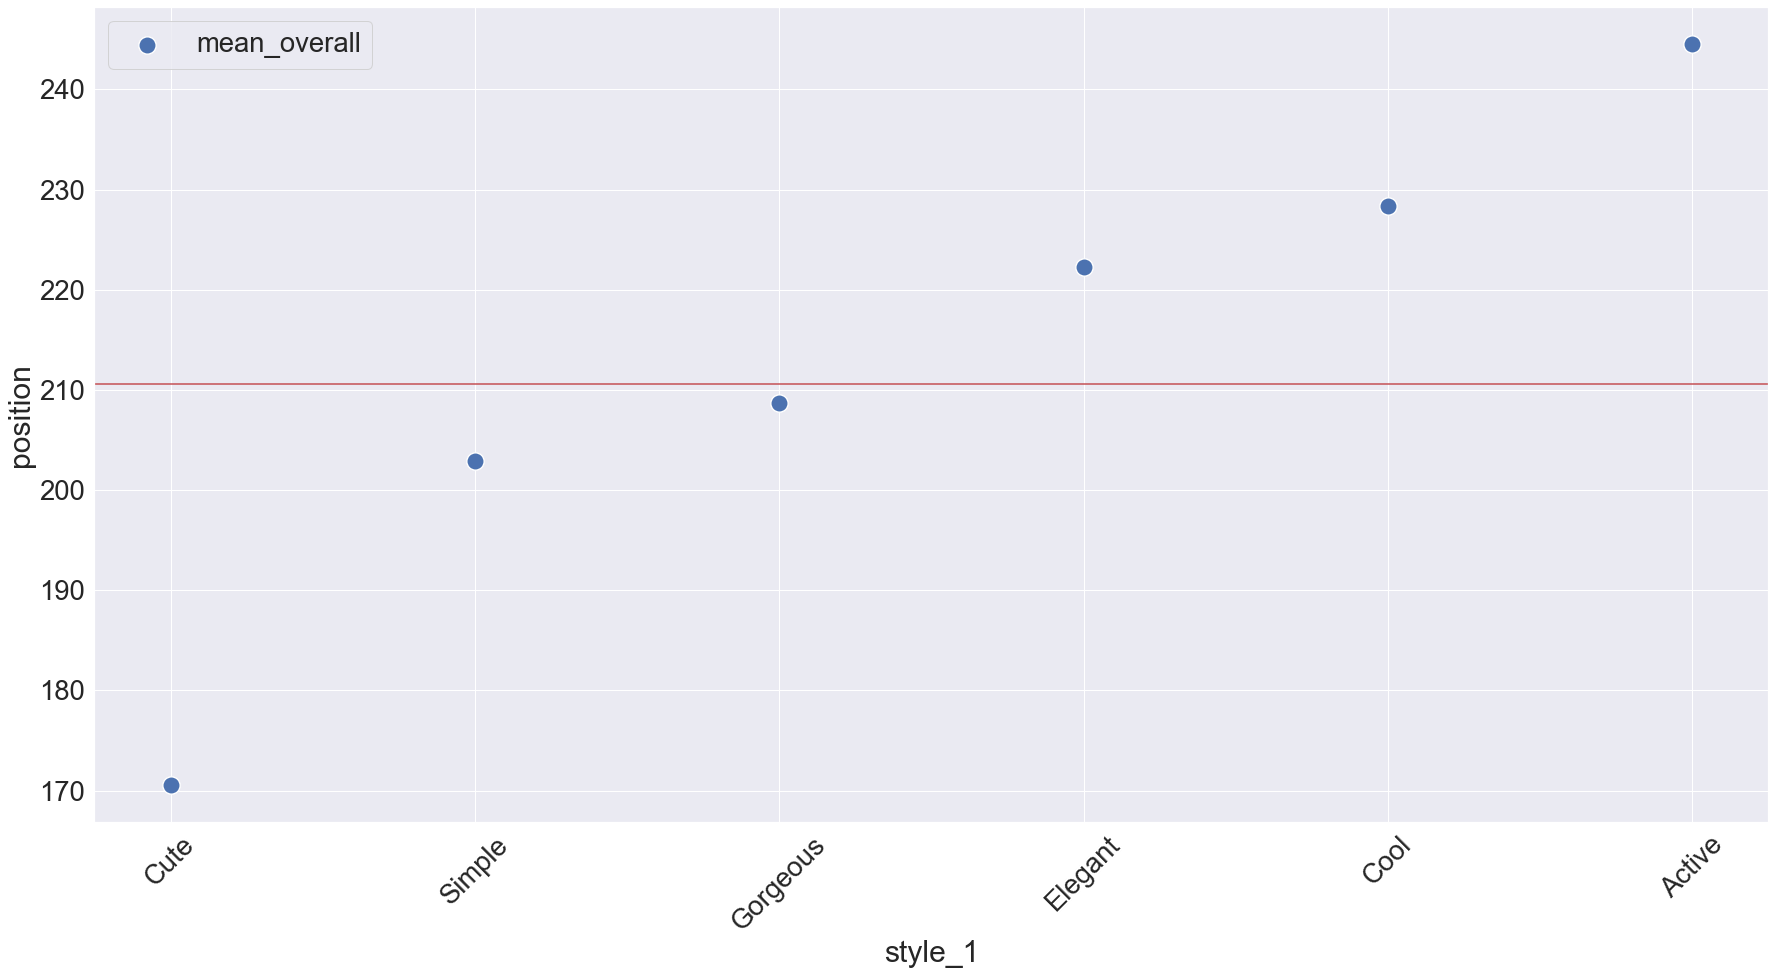

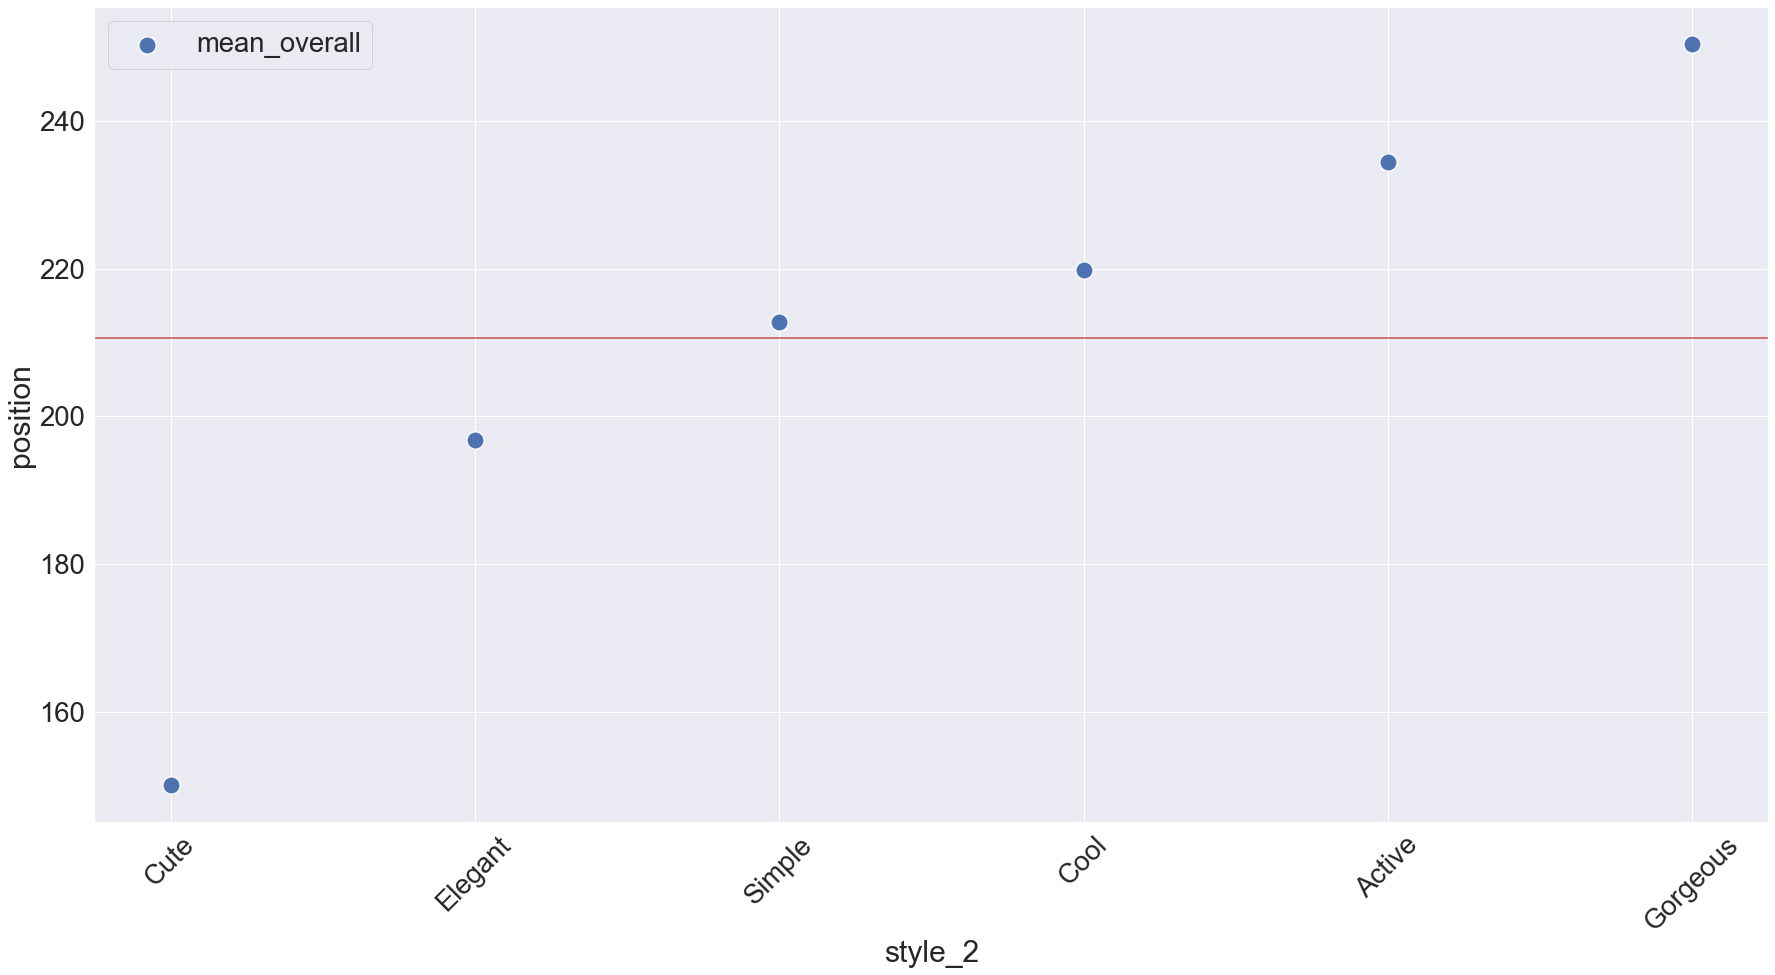

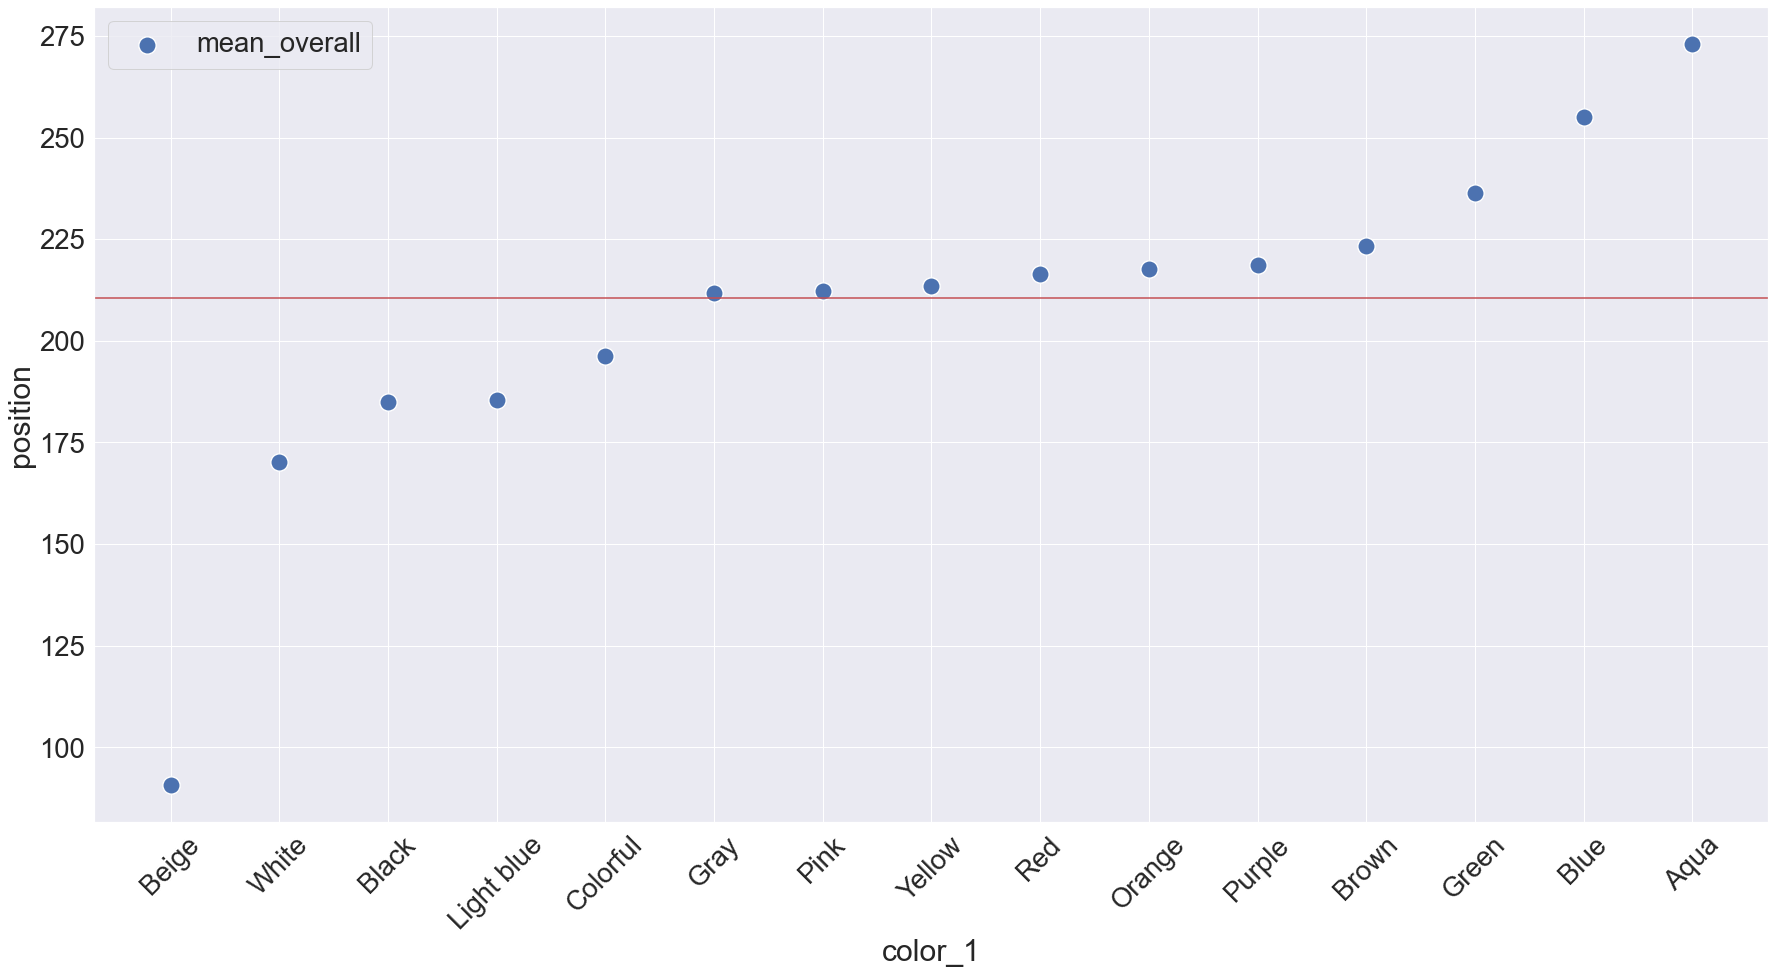

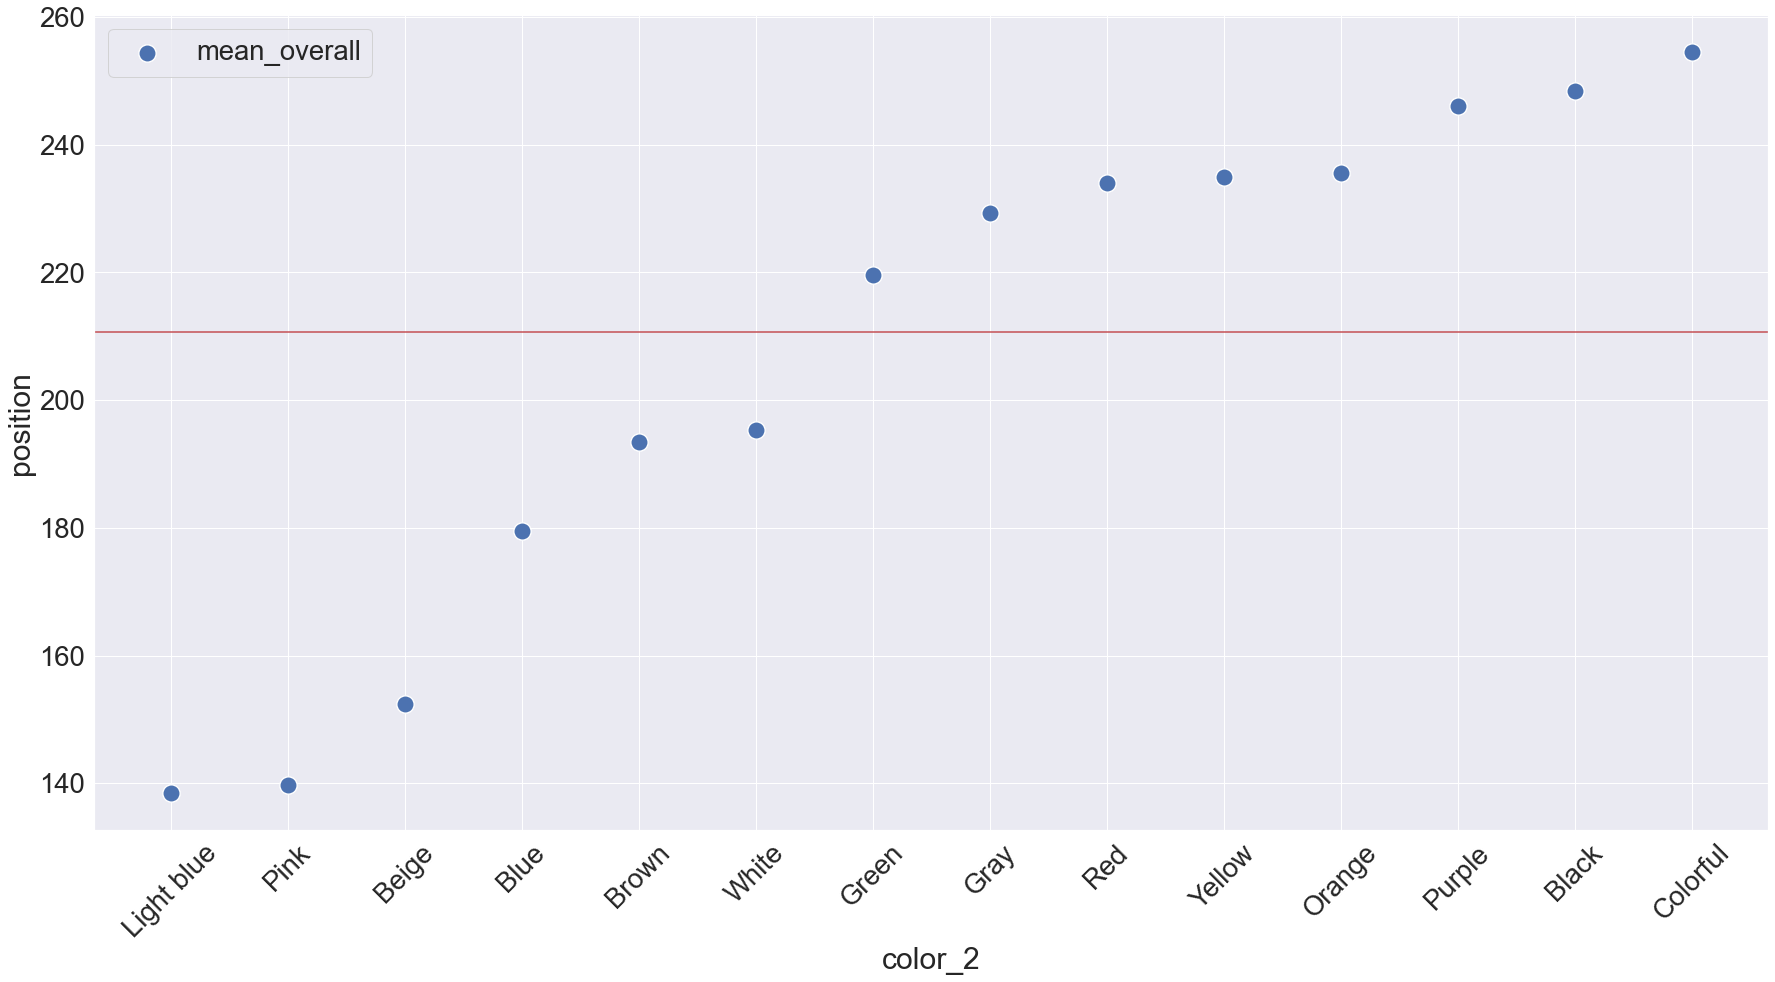

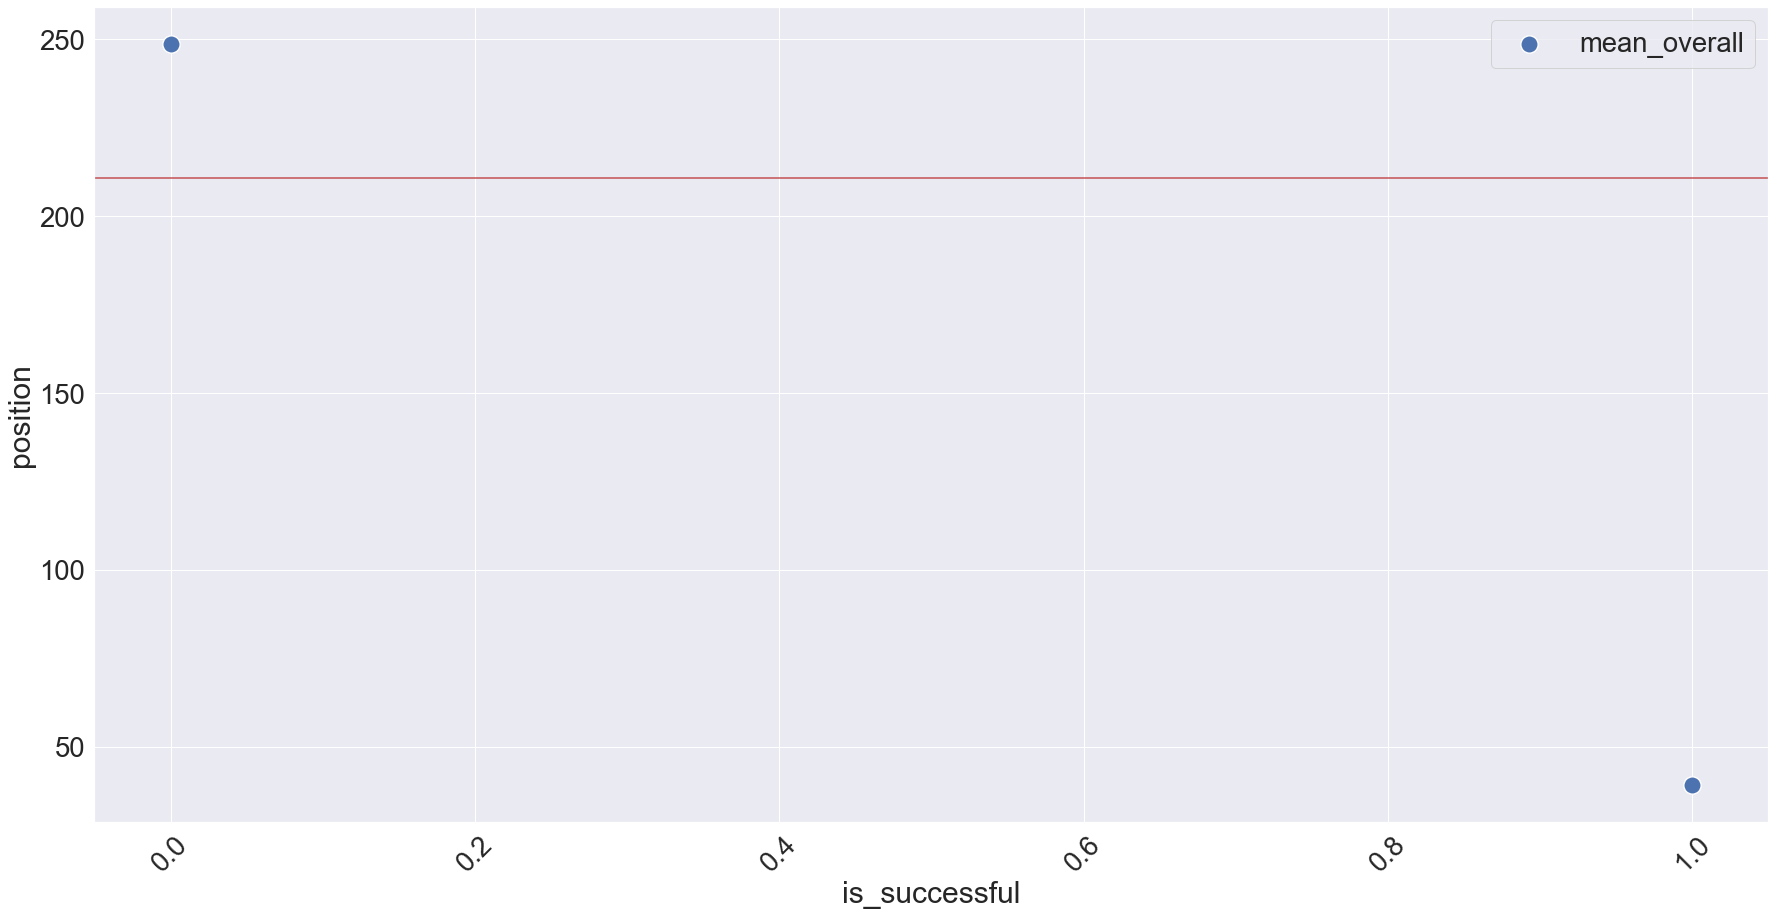

In [18]:
column_scatter_plots(train)

### Takeaways:

- The top 5 most popular species are Octopus, Wolf, Deer, Hamster, Cat
- It seems like female characters generally perform better than male characters
- The normal, peppy, lazy, and big sister personalities tend to perform better than the other personalities.
- The play and nature hobbies tend to do better than average, and the music hobby seems to perform right at average
- The cute, simple, and elegant style_1 perform better than average, while gorgeous and active perform about the same and cool performs the worst
- For the style_2 category, cute and simple still perform well, but elegant doesn't perform well at all. Additionally, cool does a lot better and active still doesn't do well.  
- For color_1 (which is typically the primary color of the character's clothes), beige, white, gray, colorful, and black perform the best while yellow, green, and purple do the worst. 
- For color_2, light blue, pink and brown do the best while black and orange do the worst
    - While aqua does extremely well, there is only a single piece of information to back it up. Because of this, I am excluding it as a top performing color
    

## Taking a deeper look to at gender as it relates to position and whether or not the character is successful

<AxesSubplot:xlabel='gender', ylabel='position'>

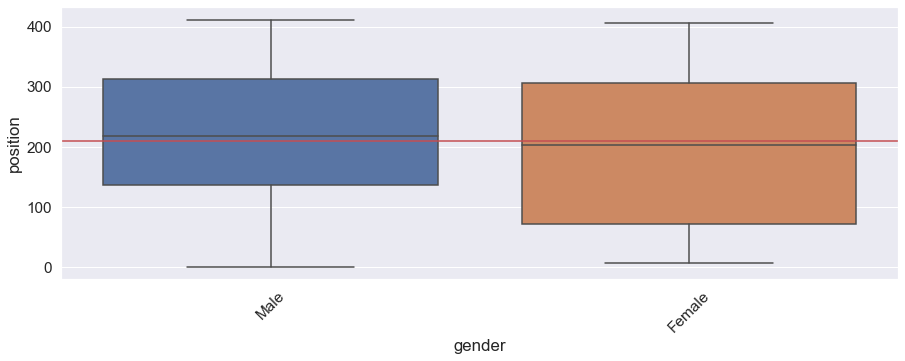

In [19]:
# create a boxplot to show the differences in position for gender
plt.figure(figsize=(15,5))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.boxplot(x='gender', y="position", data=train)

<AxesSubplot:xlabel='gender', ylabel='position'>

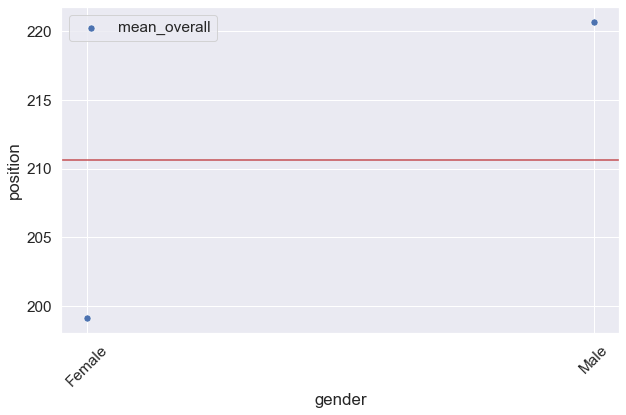

In [20]:
# pull the scatter plot from above to get a better picture of just the means
plt.figure(figsize=(10,6))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.scatterplot(x='gender', y='position', data=trait_means_dicts(train)['gender'],label='mean_overall', s=50)

In [21]:
# run a chi2 to see if there is a statistical significance between genders when it comes to if they are successful or not
# null hypothesis- there is no difference between the two genders when it comes to whether or not they are successful
# alt hypothesis- there is a difference between the two genders when it comes to whether or not they are successful

alpha = .05

gender_table = pd.crosstab(train.gender, train.is_successful)

chi2, p, degf, expected = stats.chi2_contingency(gender_table)

print('Observed\n')
print(gender_table.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[ 81  27]
 [108  15]]
---
Expected

[[ 88.36363636  19.63636364]
 [100.63636364  22.36363636]]
---

chi^2 = 5.5069
p     = 0.0189


In [22]:
if p < alpha:
    print('Reject the null')
else:
    print('Fail to reject the null')


Reject the null


Takeaway: Although there seems to be a difference in the position, it doesn't seem to be impactful enough to make a difference in whether or not the character is successful

## Taking a deeper look to at species as it relates to position and whether or not the character is successful

<AxesSubplot:xlabel='species', ylabel='position'>

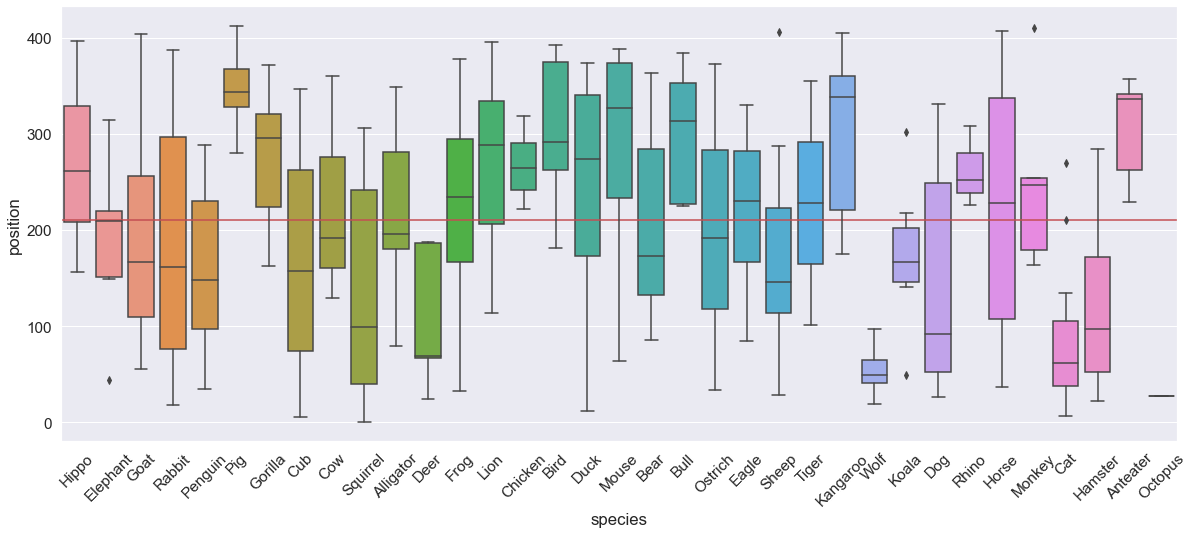

In [23]:
# create a boxplot to show the differences in position for species
plt.figure(figsize=(20,8))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.boxplot(x='species', y="position", data=train)

<AxesSubplot:xlabel='species', ylabel='position'>

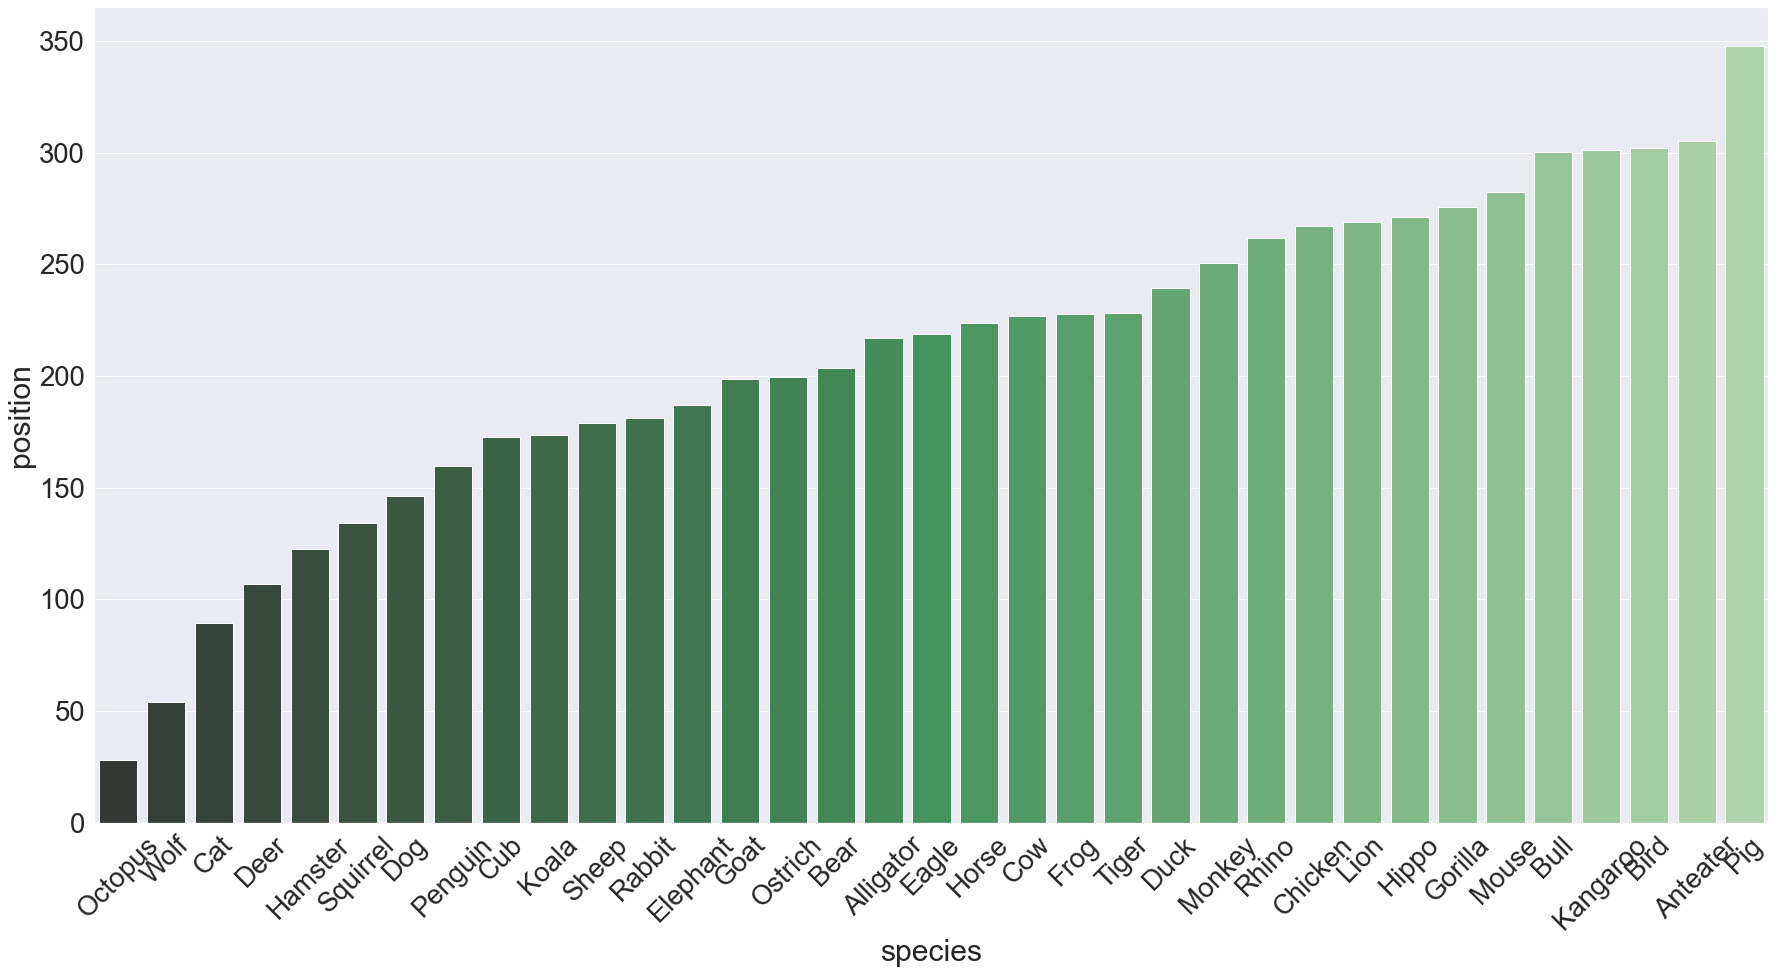

In [24]:
# creating a barplot for each of the species and the average position
plt.figure(figsize=(30,15))
sns.set(font_scale=2.5)
plt.xticks(rotation=45)
pal = sns.color_palette("Greens_d", len(trait_means_dicts(train)['species']))
sns.barplot(data = trait_means_dicts(train)['species'], x = 'species', y = 'position',palette = np.array(pal[::-1]))

In [25]:
# run a chi2 to see if there is a statistical significance between species when it comes to if they are successful or not
# null hypothesis- there is no difference between the species when it comes to whether or not they are successful
# alt hypothesis- there is a difference between the species when it comes to whether or not they are successful

alpha = .05

species_table = pd.crosstab(train.species, train.is_successful)

chi2, p, degf, expected = stats.chi2_contingency(species_table)

print('Observed\n')
print(species_table.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[ 5  0]
 [ 5  0]
 [ 8  0]
 [10  0]
 [ 5  0]
 [ 5  6]
 [ 6  0]
 [ 3  0]
 [ 7  3]
 [ 2  3]
 [ 7  4]
 [ 9  2]
 [ 4  0]
 [ 6  1]
 [10  1]
 [ 3  1]
 [ 6  0]
 [ 4  2]
 [ 3  0]
 [ 5  1]
 [ 6  0]
 [ 6  1]
 [ 6  0]
 [ 5  0]
 [ 9  1]
 [ 0  1]
 [ 5  1]
 [ 5  1]
 [ 9  0]
 [ 9  3]
 [ 3  0]
 [ 6  1]
 [ 4  4]
 [ 2  0]
 [ 1  5]]
---
Expected

[[4.09090909 0.90909091]
 [4.09090909 0.90909091]
 [6.54545455 1.45454545]
 [8.18181818 1.81818182]
 [4.09090909 0.90909091]
 [9.         2.        ]
 [4.90909091 1.09090909]
 [2.45454545 0.54545455]
 [8.18181818 1.81818182]
 [4.09090909 0.90909091]
 [9.         2.        ]
 [9.         2.        ]
 [3.27272727 0.72727273]
 [5.72727273 1.27272727]
 [9.         2.        ]
 [3.27272727 0.72727273]
 [4.90909091 1.09090909]
 [4.90909091 1.09090909]
 [2.45454545 0.54545455]
 [4.90909091 1.09090909]
 [4.90909091 1.09090909]
 [5.72727273 1.27272727]
 [4.90909091 1.09090909]
 [4.09090909 0.90909091]
 [8.18181818 1.81818182]
 [0.81818182 0.18181818]
 [4.909090

In [26]:
if p < alpha:
    print('Reject the null')
else:
    print('Fail to reject the null')

Reject the null


Takeaway: There is a relationship between species and whether or not the character is successful

## Taking a deeper look to at personality as it relates to position and whether or not the character is successful

<AxesSubplot:xlabel='personality', ylabel='position'>

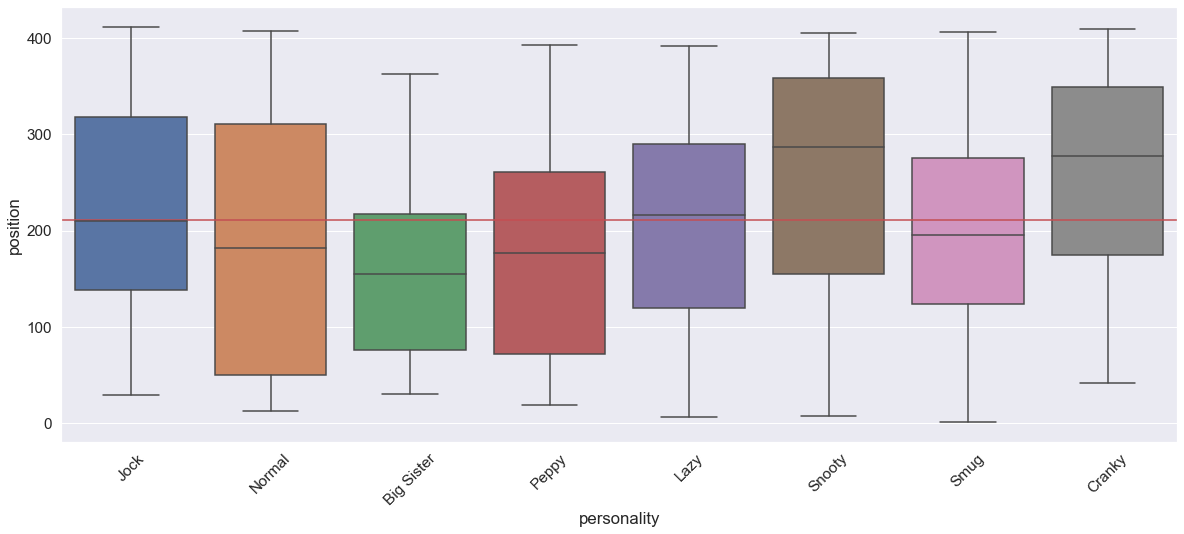

In [27]:
# create a boxplot to show the differences in position for personality
plt.figure(figsize=(20,8))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.boxplot(x='personality', y="position", data=train)

<AxesSubplot:xlabel='personality', ylabel='position'>

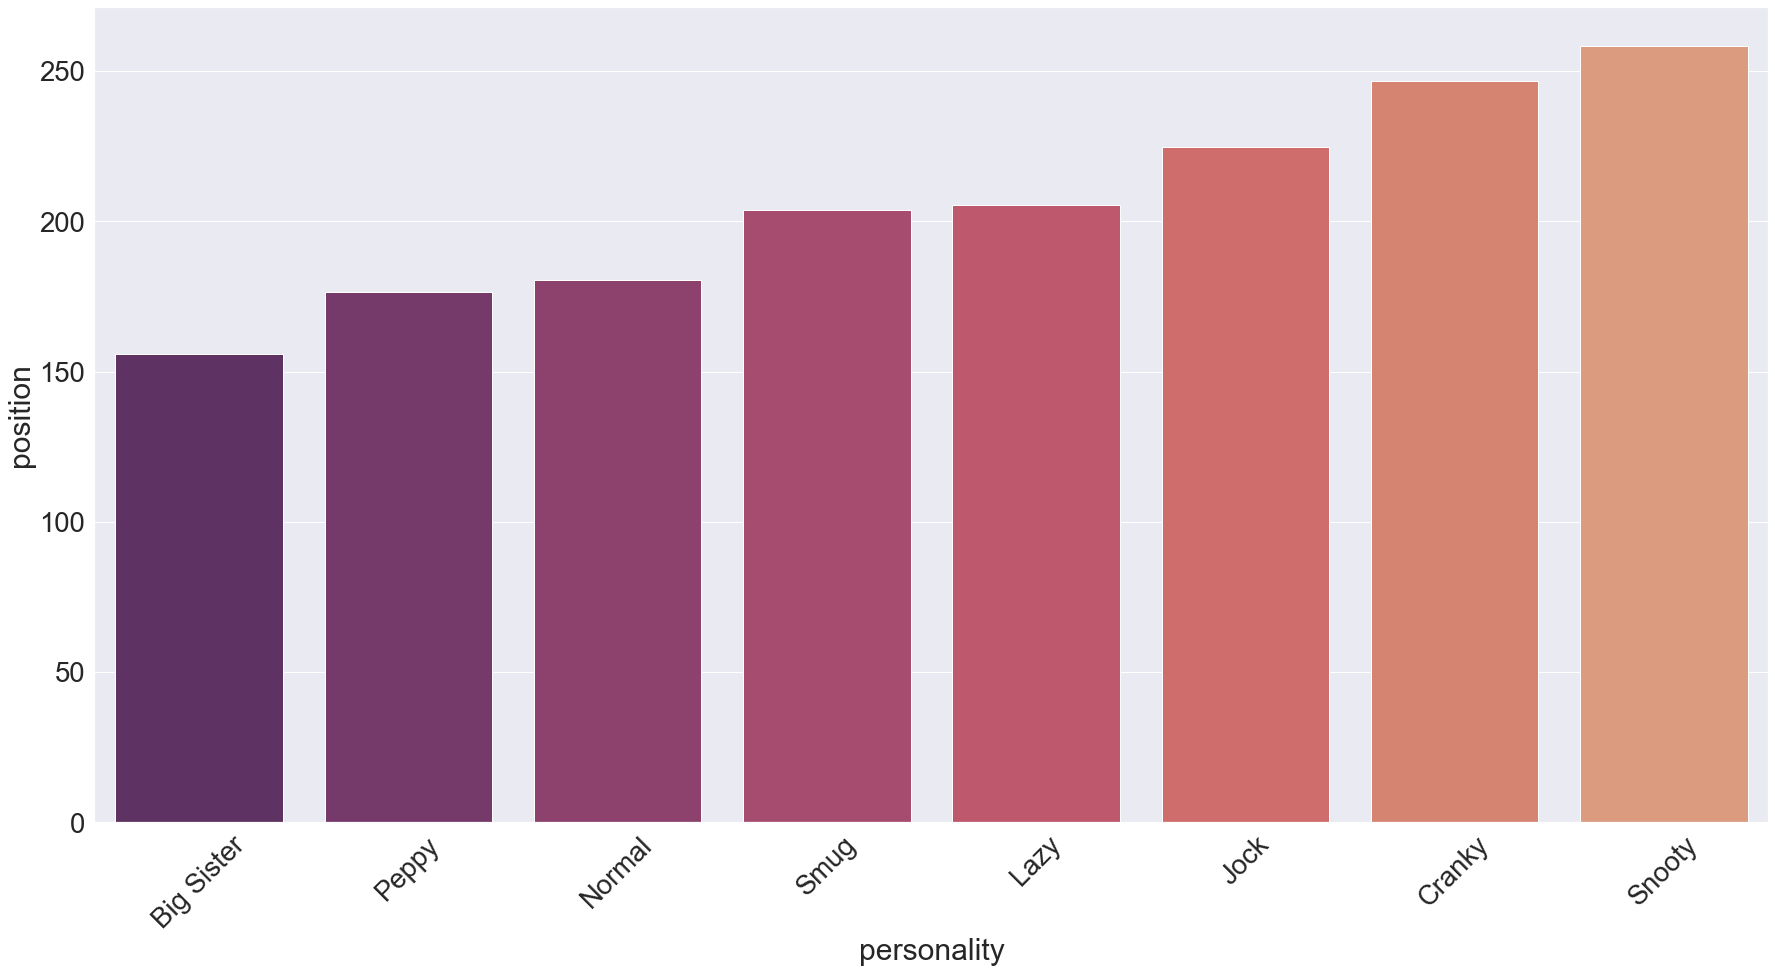

In [28]:
# creating a barplot for each of the personality and the average position
plt.figure(figsize=(30,15))
sns.set(font_scale=2.5)
plt.xticks(rotation=45)
pal = sns.color_palette("flare", len(trait_means_dicts(train)['personality']))
sns.barplot(data = trait_means_dicts(train)['personality'], x = 'personality', y = 'position',palette = np.array(pal[::-1]))

In [29]:
# run a chi2 to see if there is a statistical significance between personality when it comes to if they are successful or not
# null hypothesis- there is no difference between the personality when it comes to whether or not they are successful
# alt hypothesis- there is a difference between the personality when it comes to whether or not they are successful

alpha = .05

personality_table = pd.crosstab(train.personality, train.is_successful)

chi2, p, degf, expected = stats.chi2_contingency(personality_table)

print('Observed\n')
print(personality_table.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[ 8  3]
 [27  2]
 [33  4]
 [28  4]
 [20 12]
 [25  9]
 [20  5]
 [28  3]]
---
Expected

[[ 9.          2.        ]
 [23.72727273  5.27272727]
 [30.27272727  6.72727273]
 [26.18181818  5.81818182]
 [26.18181818  5.81818182]
 [27.81818182  6.18181818]
 [20.45454545  4.54545455]
 [25.36363636  5.63636364]]
---

chi^2 = 16.3004
p     = 0.0225


In [30]:
if p < alpha:
    print('Reject the null')
else:
    print('Fail to reject the null')

Reject the null


Takeaway: While it does seem like there is a statistical difference between the personalities, it isn't strong enough to be considered a large factor when determining whether or not a character will be successful

## Taking a deeper look to at style_1 as it relates to position and whether or not the character is successful

<AxesSubplot:xlabel='style_1', ylabel='position'>

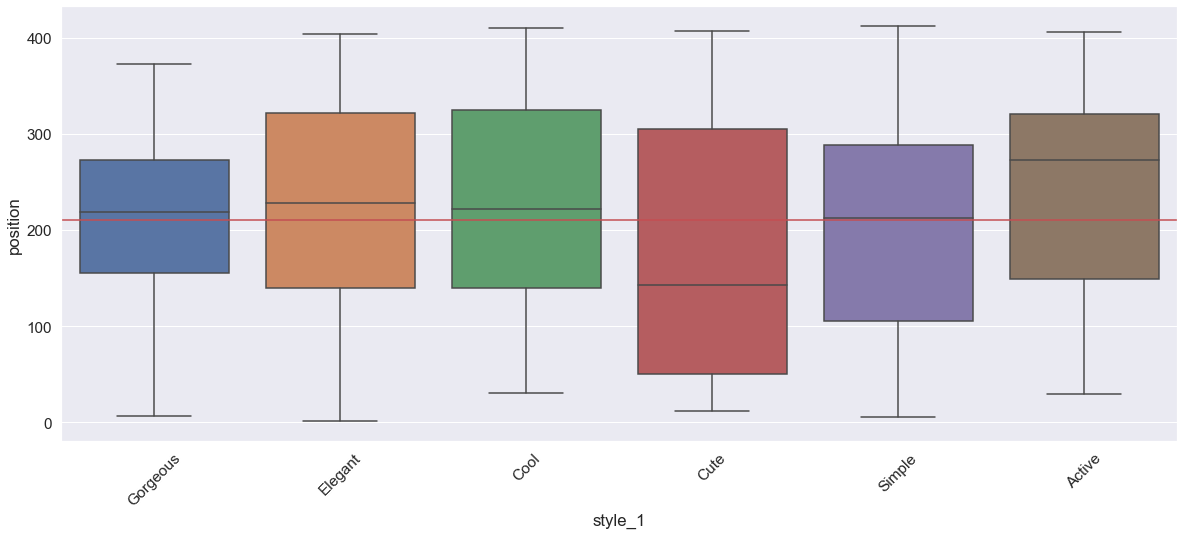

In [31]:
# create a boxplot to show the differences in position for style_1
plt.figure(figsize=(20,8))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.boxplot(x='style_1', y="position", data=train)

<AxesSubplot:xlabel='style_1', ylabel='position'>

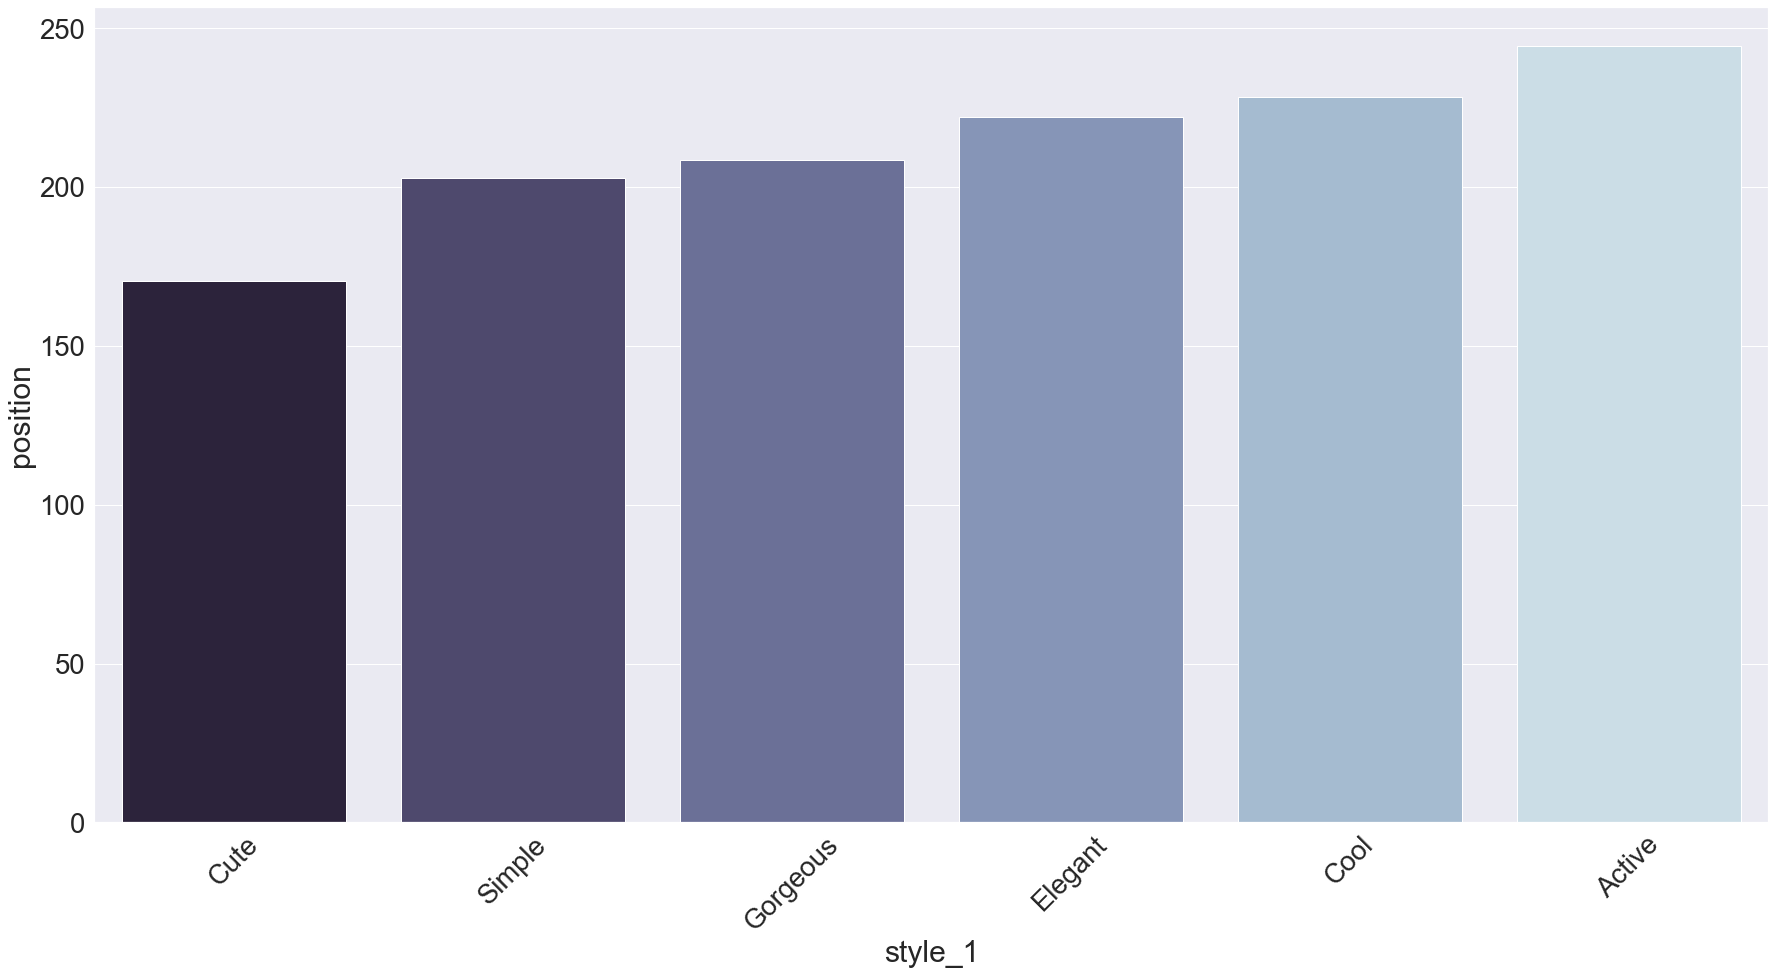

In [32]:
# creating a barplot for each of the style_1 and the average position
plt.figure(figsize=(30,15))
sns.set(font_scale=2.5)
plt.xticks(rotation=45)
pal = sns.color_palette("ch:s=.25,rot=-.25", len(trait_means_dicts(train)['style_1']))
sns.barplot(data = trait_means_dicts(train)['style_1'], x = 'style_1', y = 'position',palette = np.array(pal[::-1]))

In [33]:
# run a chi2 to see if there is a statistical significance between style_1 when it comes to if they are successful or not
# null hypothesis- there is no difference between the style_1 when it comes to whether or not they are successful
# alt hypothesis- there is a difference between the style_1 when it comes to whether or not they are successful

alpha = .05

style_1_table = pd.crosstab(train.style_1, train.is_successful)

chi2, p, degf, expected = stats.chi2_contingency(style_1_table)

print('Observed\n')
print(style_1_table.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[28  3]
 [39  4]
 [27 16]
 [31  5]
 [13  3]
 [51 11]]
---
Expected

[[25.36363636  5.63636364]
 [35.18181818  7.81818182]
 [35.18181818  7.81818182]
 [29.45454545  6.54545455]
 [13.09090909  2.90909091]
 [50.72727273 11.27272727]]
---

chi^2 = 14.7089
p     = 0.0117


In [34]:
if p < alpha:
    print('Reject the null')
else:
    print('Fail to reject the null')

Reject the null


Takeaway: There isn't any real difference between the personalities when it comes to whether or not they are successful

## Taking a deeper look to at hobby as it relates to position and whether or not the character is successful

<AxesSubplot:xlabel='hobby', ylabel='position'>

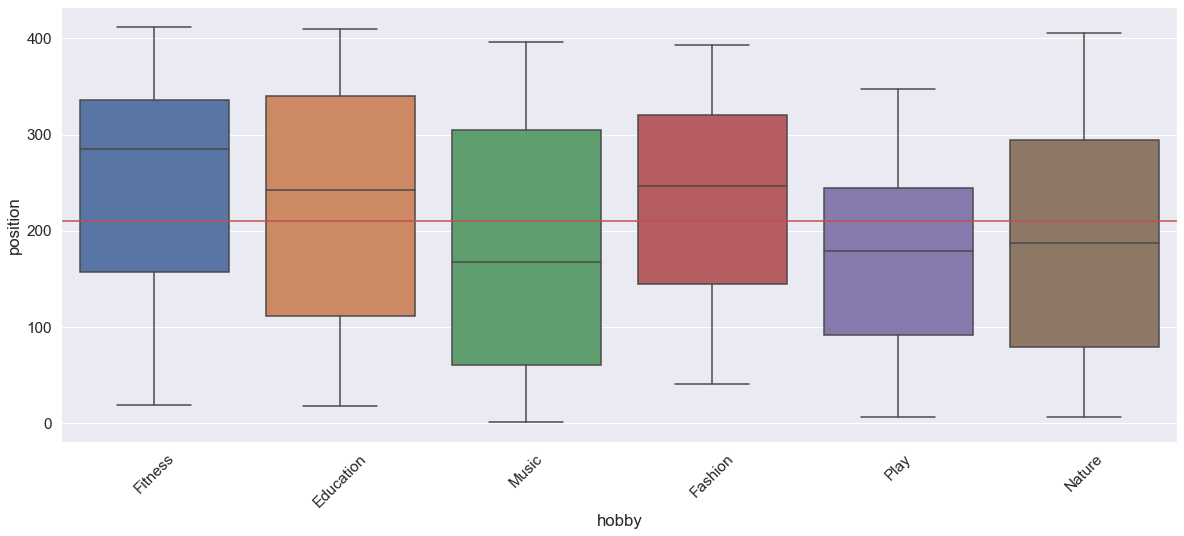

In [35]:
# create a boxplot to show the differences in position for hobby
plt.figure(figsize=(20,8))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.boxplot(x='hobby', y="position", data=train)

<AxesSubplot:xlabel='hobby', ylabel='position'>

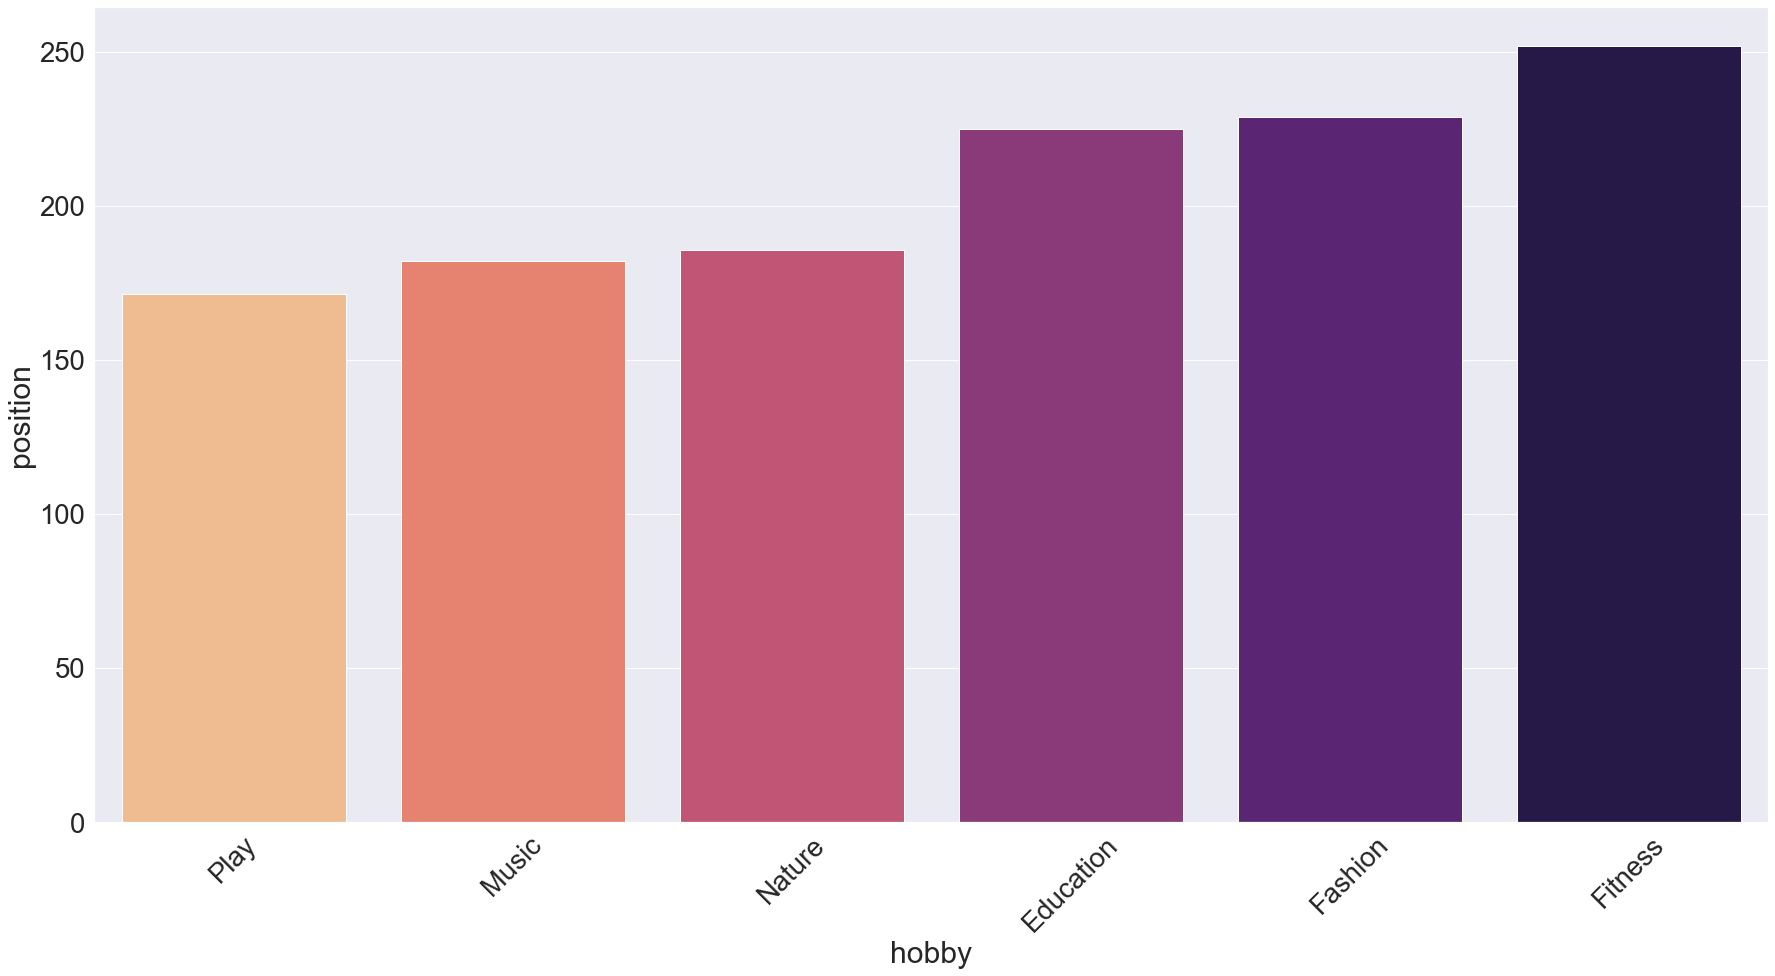

In [36]:
# creating a barplot for each of the hobby and the average position
plt.figure(figsize=(30,15))
sns.set(font_scale=2.5)
plt.xticks(rotation=45)
pal = sns.color_palette("magma", len(trait_means_dicts(train)['hobby']))
sns.barplot(data = trait_means_dicts(train)['hobby'], x = 'hobby', y = 'position',palette = np.array(pal[::-1]))

In [37]:
# run a chi2 to see if there is a statistical significance between hobby when it comes to if they are successful or not
# null hypothesis- there is no difference between the hobby when it comes to whether or not they are successful
# alt hypothesis- there is a difference between the hobby when it comes to whether or not they are successful

alpha = .05

hobby_table = pd.crosstab(train.hobby, train.is_successful)

chi2, p, degf, expected = stats.chi2_contingency(hobby_table)

print('Observed\n')
print(hobby_table.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[33  6]
 [37  5]
 [42  4]
 [20 10]
 [28  9]
 [29  8]]
---
Expected

[[31.90909091  7.09090909]
 [34.36363636  7.63636364]
 [37.63636364  8.36363636]
 [24.54545455  5.45454545]
 [30.27272727  6.72727273]
 [30.27272727  6.72727273]]
---

chi^2 = 9.9625
p     = 0.0763


In [38]:
if p < alpha:
    print('Reject the null')
else:
    print('Fail to reject the null')

Fail to reject the null


Takeaway: There is a relationship between the hobby and whether or not the character is successful

## Taking a deeper look to at color_1 as it relates to position and whether or not the character is successful

<AxesSubplot:xlabel='color_1', ylabel='position'>

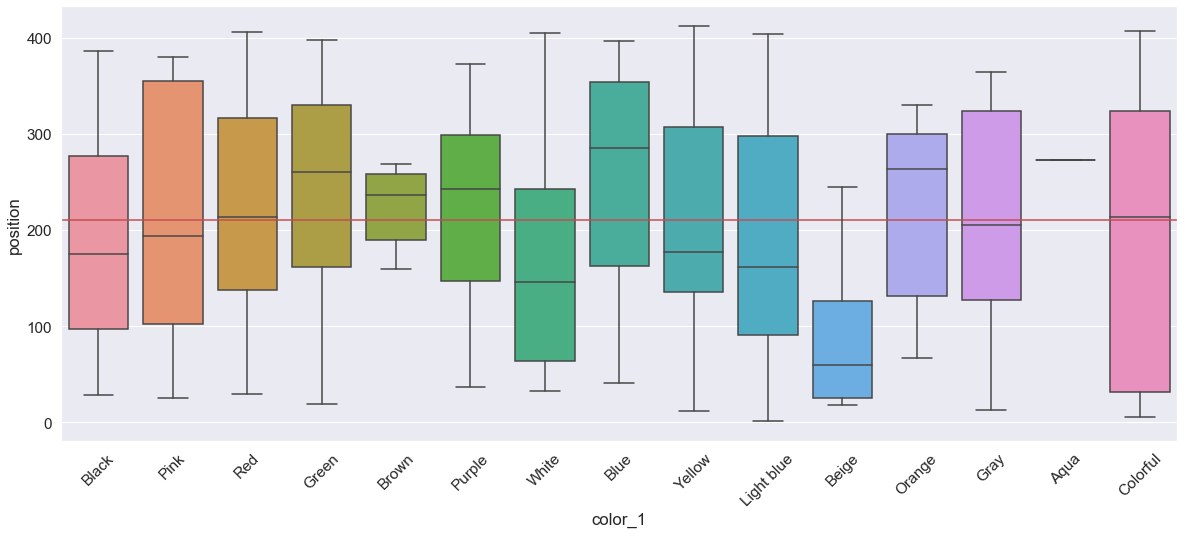

In [39]:
# create a boxplot to show the differences in position for color_1
plt.figure(figsize=(20,8))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.boxplot(x='color_1', y="position", data=train)

<AxesSubplot:xlabel='color_1', ylabel='position'>

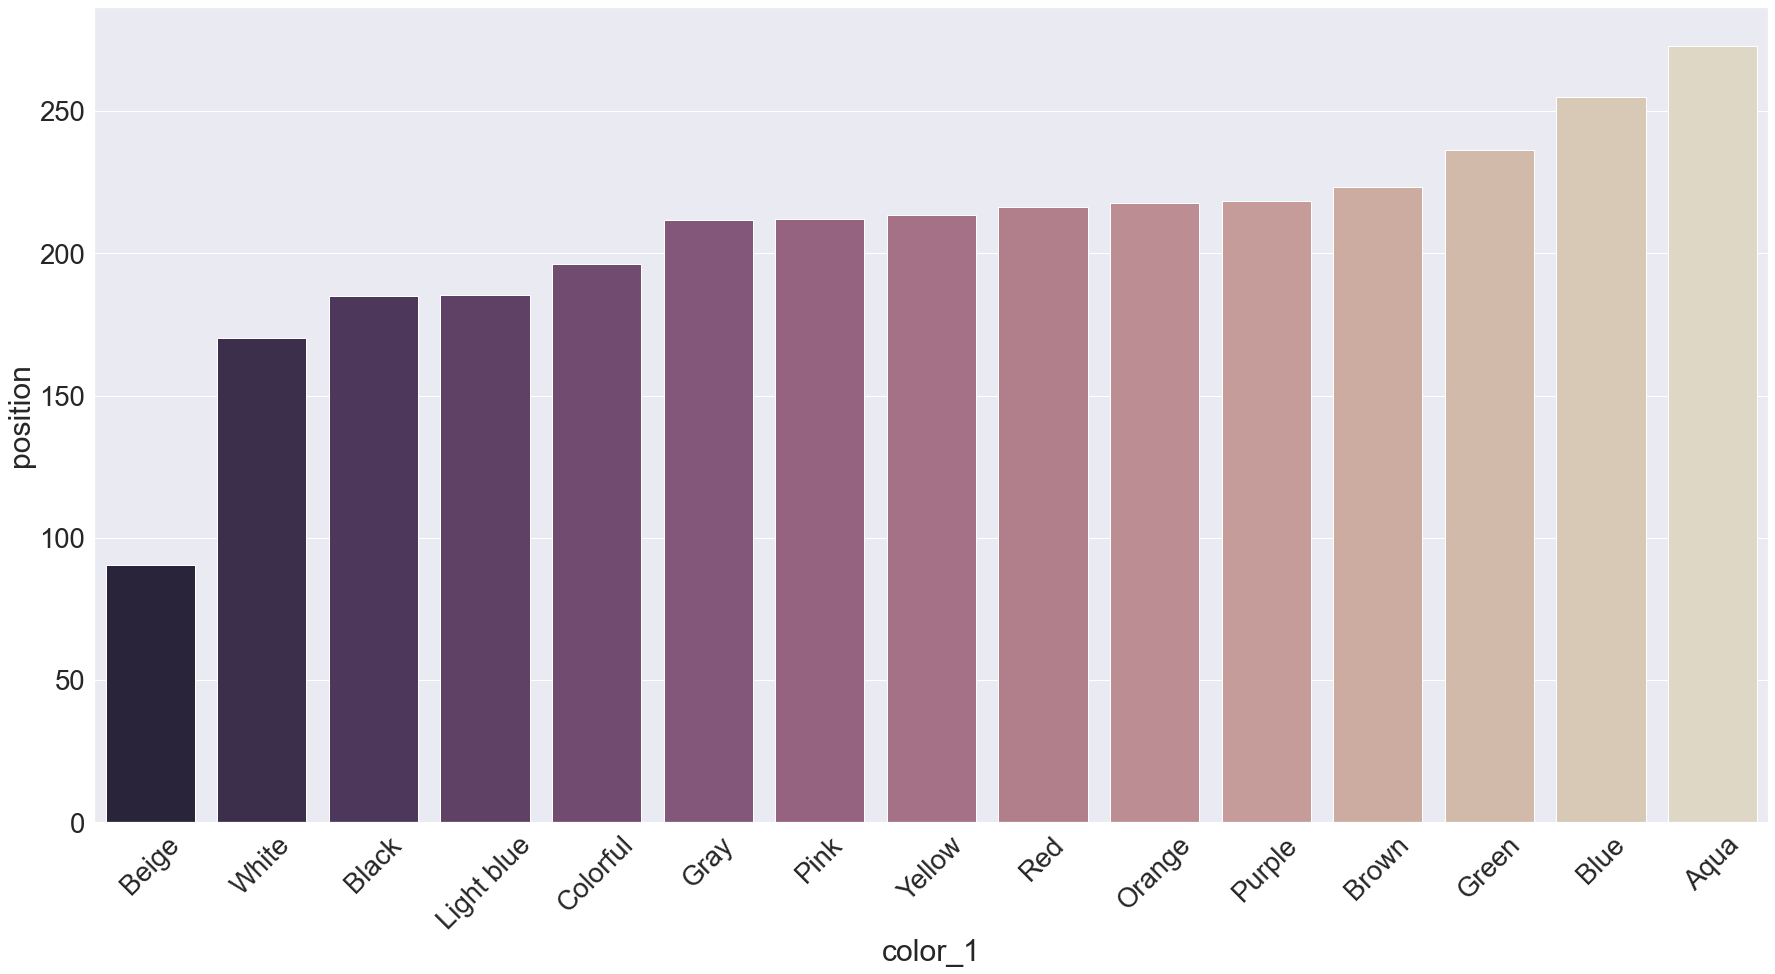

In [40]:
# creating a barplot for each of the color_1 and the average position
plt.figure(figsize=(30,15))
sns.set(font_scale=2.5)
plt.xticks(rotation=45)
pal = sns.color_palette("ch:s=-.2,r=.6", len(trait_means_dicts(train)['color_1']))
sns.barplot(data = trait_means_dicts(train)['color_1'], x = 'color_1', y = 'position',palette = np.array(pal[::-1]))

In [41]:
# run a chi2 to see if there is a statistical significance between color_1 when it comes to if they are successful or not
# null hypothesis- there is no difference between the color_1 when it comes to whether or not they are successful
# alt hypothesis- there is a difference between the color_1 when it comes to whether or not they are successful

alpha = .05

color_1_table = pd.crosstab(train.color_1, train.is_successful)

chi2, p, degf, expected = stats.chi2_contingency(color_1_table)

print('Observed\n')
print(color_1_table.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[ 1  0]
 [ 3  3]
 [24  5]
 [22  3]
 [ 6  0]
 [ 8  4]
 [ 8  1]
 [22  5]
 [ 9  2]
 [10  1]
 [12  3]
 [15  3]
 [25  6]
 [ 9  4]
 [15  2]]
---
Expected

[[ 0.81818182  0.18181818]
 [ 4.90909091  1.09090909]
 [23.72727273  5.27272727]
 [20.45454545  4.54545455]
 [ 4.90909091  1.09090909]
 [ 9.81818182  2.18181818]
 [ 7.36363636  1.63636364]
 [22.09090909  4.90909091]
 [ 9.          2.        ]
 [ 9.          2.        ]
 [12.27272727  2.72727273]
 [14.72727273  3.27272727]
 [25.36363636  5.63636364]
 [10.63636364  2.36363636]
 [13.90909091  3.09090909]]
---

chi^2 = 11.0108
p     = 0.6852


In [42]:
if p < alpha:
    print('Reject the null')
else:
    print('Fail to reject the null')

Fail to reject the null


Takeaway: While it does seem like there is a slight statistical significance for color 1, it isn't strong enough to be considered a large factor when determining whether or not a character will be successful

# Exploration Takeaways:
- There are factors that can help in determining whether or not a character will be successful. In order of significance they are:
    - Species, hobby, personality, and color_1
    - While personality and significance weren't particularly statistically significant, I still decided to include them as significant to use them in modeling
- Gender and Style_1 didn't hold any real particular significance when determining whether or not a character will be successful

# Modeling

In [43]:
# I am going to encode the species, hobby, personality, and color_1 columns to use them for modeling
train = wrangle.encode_all_vars(train)

validate = wrangle.encode_all_vars(validate)

test = wrangle.encode_all_vars(test)

X_train = train.drop(columns=["is_successful"])
y_train = train.is_successful

X_validate = validate.drop(columns=["is_successful"])
y_validate = validate.is_successful

X_test = test.drop(columns=["is_successful"])
y_test = test.is_successful

In [44]:
train.T

Name,Biff,Margie,Pashmina,Bunnie,Boomer,Lucy,Violet,Marty,Norma,Agent S,...,Stu,Stinky,Rudy,Drake,Jambette,Simon,Marcie,Spork,Harry,Miranda
is_successful,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
is_music,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
is_nature,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
is_education,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
is_fashion,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
is_play,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,1,0,1,0,0
is_fitness,1,0,0,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
is_beige,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
is_white,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
is_black,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df.shape

(413, 12)

In [46]:
# Since I am dealing with categorical data exclusively, I am going to do a decision tree
# I am going to look at a max depth of a range from 2 to 21 and focus on recall for the 1 character

for i in range(2, 21):
    tree = DecisionTreeClassifier(max_depth=i, random_state=17)
    tree = tree.fit(X_train, y_train)
    y_predictions = tree.predict(X_train)

    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                             0                    1             accuracy  \
precision                 0.85                 0.67                 0.84   
recall                    0.97                 0.24                 0.84   
f1-score                  0.91                 0.35                 0.84   
support                 189.00                42.00                 0.84   

                     macro avg         weighted avg  
precision                 0.76                 0.82  
recall                    0.61                 0.84  
f1-score                  0.63                 0.81  
support                 231.00               231.00  

Tree with max depth of 3
                             0                    1             accuracy  \
precision                 0.85                 0.82                 0.85   
recall                    0.99                 0.21                 0.85   
f1-score                  0.91                 0.34                 0.

In [47]:
tree = DecisionTreeClassifier(max_depth=4, random_state=17)
tree = tree.fit(X_train, y_train)
y_predictions = tree.predict(X_train)

report = classification_report(y_train, y_predictions, output_dict=True)
print(f"Tree with max depth of {4}")
print(pd.DataFrame(report))
print()

Tree with max depth of 4
                             0                    1             accuracy  \
precision                 0.86                 0.86                 0.86   
recall                    0.99                 0.29                 0.86   
f1-score                  0.92                 0.43                 0.86   
support                 189.00                42.00                 0.86   

                     macro avg         weighted avg  
precision                 0.86                 0.86  
recall                    0.64                 0.86  
f1-score                  0.67                 0.83  
support                 231.00               231.00  



In [48]:
tree = DecisionTreeClassifier(max_depth=4, random_state=17)
tree = tree.fit(X_validate, y_validate)
y_predictions = tree.predict(X_validate)

report = classification_report(y_validate, y_predictions, output_dict=True)
print(f"Tree with max depth of {4}")
print(pd.DataFrame(report))
print()

Tree with max depth of 4
                             0                    1             accuracy  \
precision                 0.92                 0.92                 0.92   
recall                    0.99                 0.61                 0.92   
f1-score                  0.95                 0.73                 0.92   
support                  81.00                18.00                 0.92   

                     macro avg         weighted avg  
precision                 0.92                 0.92  
recall                    0.80                 0.92  
f1-score                  0.84                 0.91  
support                  99.00                99.00  



A decision tree with a max depth of 4 gives us an accuracy of 92% in validate and keeps us from being overfitted. 

### KNN

In [50]:
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')

In [51]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [52]:
y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.88


In [53]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       189
           1       0.83      0.45      0.58        42

    accuracy                           0.88       231
   macro avg       0.86      0.72      0.76       231
weighted avg       0.88      0.88      0.87       231



### Run against validate

In [54]:
knn.fit(X_validate, y_validate)

KNeighborsClassifier(n_neighbors=3)

In [55]:
y_pred = knn.predict(X_validate)
y_pred_proba = knn.predict_proba(X_validate)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on training set: 0.86


In [56]:
print(classification_report(y_validate,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92        81
           1       0.67      0.44      0.53        18

    accuracy                           0.86        99
   macro avg       0.78      0.70      0.72        99
weighted avg       0.85      0.86      0.85        99



The accuracy on KNN isn't as good, so we will stick with the decision tree for the testing phase

# Final model

In [49]:
tree = DecisionTreeClassifier(max_depth=4, random_state=17)
tree = tree.fit(X_test, y_test)
y_predictions = tree.predict(X_test)

report = classification_report(y_test, y_predictions, output_dict=True)
print(f"Tree with max depth of {4}")
print(pd.DataFrame(report))
print()

Tree with max depth of 4
                             0                    1             accuracy  \
precision                 0.95                 0.86                 0.94   
recall                    0.99                 0.60                 0.94   
f1-score                  0.97                 0.71                 0.94   
support                  73.00                10.00                 0.94   

                     macro avg         weighted avg  
precision                 0.90                 0.94  
recall                    0.79                 0.94  
f1-score                  0.84                 0.94  
support                  83.00                83.00  

